In [7]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline

import csv
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import warnings
from csv_reader import read_csv
from aux import set_smallest_n_zero
from disp import set_font_size
from copy import deepcopy as copy
from analysis_tools import *
from pathlib import Path
from csv_reader import read_csv
from csv_writer import write_csv
from scipy import stats

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)

plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 3.0
plt.rc('font', family='serif')

warnings.filterwarnings('ignore')

rule_names = [ # Define labels for all rules to be run during simulations
    r'Const',
    r'$y$',
    r'$x$',
    r'$x \, y$',
    r'$y_{int}$',
    r'$x \, y_{int}$',
    r'$x_{int}$',
    r'$x_{int} \, y$',
    r'$y_{int} \, y$',
    r'$x_{int} \, x$',

    r'$w$',
    r'$w \, y$',
    r'$w \, x$',
    r'$w \, x \, y$',
    r'$w y_{int}$',
    r'$w x \, y_{int}$',
    r'$w x_{int}$',
    r'$w x_{int} \, y$',
    r'$w y_{int} \, y$',
    r'$w x_{int} \, x$',
]

time_constants = [
    r'$\tau \, y_{int}$',
    r'$\tau \, x \, y_{int}$',
    r'$\tau \, x_{int}$',
    r'$\tau \, x_{int} \, y$',
    r'$\tau \, y_{int} \, y$',
    r'$\tau \, x_{int} \, x$',
    
    r'$\tau \, w y_{int}$',
    r'$\tau \, w x \, y_{int}$',
    r'$\tau \, w x_{int}$',
    r'$\tau \, w x_{int} \, y$',
    r'$\tau \, w y_{int} \, y$',
    r'$\tau \, w x_{int} \, x$',
]

general_rule_names = copy(rule_names)

rule_names = [
    [r'$E \rightarrow E$ ' + r_name for r_name in rule_names],
    [r'$E \rightarrow I$ ' + r_name for r_name in rule_names],
    [r'$I \rightarrow E$ ' + r_name for r_name in rule_names],
]
rule_names = np.array(rule_names).flatten()

In [8]:
def plot_opt_run(file_name, n_plasticity_coefs, n_time_constants, batch_size, start=0, yscale=None, n_categories=1, loss_yscale=None):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    test_data_path = f'./sims_out/{file_name}/test_data.csv'
    
    df_train = read_csv(train_data_path, read_header=False, start=1)
    df_test = read_csv(test_data_path, read_header=False, start=1)
    
    # plot synaptic effects per rule
    scale = 1.5
    fig, axs = plt.subplots(1, 2, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Rule coefficient')
    if yscale is not None:
        axs[0].set_ylim(0, yscale)
    
    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    x = np.arange(df_train.shape[0])[start:]
    x_test = np.arange(df_test.shape[0])[start:]
    losses = df_train[df_train.columns[1]][start:]
    x_mins = []

    for i in range(0, len(x), 15):
        x_mins.append(np.argmin(losses[i:i+15]) + i)
        
    x_mins = np.array(x_mins)
    x_best_min = np.argmin(losses)
    
    x_test = df_test[df_test.columns[0]]
    losses_test = df_test[df_test.columns[1]]
    x_best_test_min = np.argmin(losses_test)
    
    final_syn_effects = []
    final_coefs = []
    
    for i in range(syn_effect_start, syn_effect_end):
#         axs[0].plot(df_train[df_train.columns[0]][start:][x_mins], df_train[df_train.columns[i]][start:][x_mins])
        
        final_syn_effects.append(df_train[df_train.columns[i]][start:][x_best_min])
        
    final_syn_effects = np.array(final_syn_effects)
        
    axs[1].plot(x_mins[1:-1], losses[x_mins[1:-1]], color='black')
    axs[1].plot(x_test, losses_test, color='blue')
    axs[1].set_ylim(0, 5000)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
        
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants
    
    cmap = matplotlib.cm.get_cmap('nipy_spectral')
    colors = [cmap(x) for x in np.linspace(0, 1, n_plasticity_coefs + n_time_constants)]
    np.random.shuffle(colors)
    
    for i in range(plasticity_coefs_start, plasticity_coefs_end):
        axs[0].plot(df_train[df_train.columns[0]][start:][x_mins], df_train[df_train.columns[i]][start:][x_mins], color=colors[i - plasticity_coefs_start])
        final_coefs.append(df_train[df_train.columns[i]][start:][x_best_min])
        
    final_coefs_test = []
    
    for i in range(plasticity_coefs_start, plasticity_coefs_end):
        final_coefs_test.append(df_test[df_test.columns[i]][start:][x_best_test_min])
        
    set_font_size(axs[0], 20)
    set_font_size(axs[1], 20)
    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'loss_and_coef_evo.png'))
    fig.savefig(os.path.join(figure_path, 'loss_and_coef_evo.svg'))
    
    final_coefs = np.array(final_coefs)
    
    # plot the synaptic effects of each plasticity rule (unsorted by size)
    scale = 2
    fig, axs = plt.subplots(n_categories, 1, figsize=(6 * scale, 3 * n_categories * scale))
    if n_categories == 1:
        axs = [axs]
    
    partial_rules_len = int(len(final_syn_effects) / n_categories)

    for l in range(n_categories):
        format_axs(axs[l])
        x = np.arange(partial_rules_len)
        y = final_syn_effects[l * partial_rules_len: (l+1) * partial_rules_len]
        colors = np.where(final_coefs[l * partial_rules_len: (l+1) * partial_rules_len] > 0, 'green', 'red')
#         y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
        axs[l].bar(x, y, color=colors, alpha=0.3)
        axs[l].set_xticks(np.arange(partial_rules_len))
        axs[l].set_xticklabels(rule_names[l * partial_rules_len: (l+1) * partial_rules_len], rotation=60, ha='right')
        axs[l].set_ylabel('Absolute synaptic change')
        axs[l].set_xlim(-1, partial_rules_len)    
    
        set_font_size(axs[l], 20)
        

    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'final_syn_change.png'))
    fig.savefig(os.path.join(figure_path, 'final_syn_change.svg'))
    
    # plot entropy of synaptic change per rule against epochs
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Entropy')
    
    entropy = []
    for i in x_mins[1:]:
        syn_effects_i = np.array(df_train.iloc[i][syn_effect_start:syn_effect_end])
        entropy.append(calc_entropy(syn_effects_i))
        
    entropy = np.array(entropy)
    
    axs.plot(x_mins[1:], entropy, c='green')
    
    scale = 2
    fig2, axs2 = plt.subplots(1, 1, figsize=(2.5 * scale, 6 * scale))
#     format_axs(axs2)

    x = np.concatenate([np.arange(n_plasticity_coefs), np.arange(n_plasticity_coefs + 1, n_plasticity_coefs + 1 + n_time_constants)])
    y = np.array(final_coefs)
    axs2.barh(x, y, alpha=0.5, color=['#1128d4'] * n_plasticity_coefs + ['#6528de'] * n_time_constants)
#     axs2.errorbar(x, y, yerr=final_plasticity_coef_stds, ls='none', color='black')
    
    axs2.set_ylim(len(x) + 1, -1)
    axs2.set_yticks(np.arange(len(x) + 1))
    tick_labels = list(general_rule_names[:len(x)]) + [''] + time_constants
    axs2.set_yticklabels(tick_labels, rotation=0)
    axs2.set_xlabel('Duration (s)')
    axs2_twin = axs2.twiny()
    axs2_twin.set_xlabel('Coefficient')
    
    axs2.spines['right'].set_visible(False)
    axs2_twin.spines['right'].set_visible(False)
    
    x_lim = np.max(np.abs(y)) * 1.02
    
    axs2.set_xlim(-x_lim, x_lim)
    plt.locator_params(axis='x', nbins=3)
    axs2_twin.set_xlim(-x_lim, x_lim)
    plt.locator_params(axis='x', nbins=3)
    
    set_font_size(axs2, 20)
    set_font_size(axs2_twin, 20)

    return np.array(final_syn_effects), np.array(final_coefs), losses[x_best_min]

In [9]:
def plot_all_opt_runs(all_files, n_plasticity_coefs, n_time_constants, batch_size, n_categories=3, l_thresh=1000, name='default'):
    figure_path = f'./figures/{name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    final_syn_effects = []
    final_plasticity_coefs = []

    for f in all_files:
        syn_effects_for_f, plasticity_coefs_for_f, best_loss_for_f = plot_opt_run(f, n_plasticity_coefs, n_time_constants, batch_size, n_categories=n_categories)
        if best_loss_for_f < l_thresh:
            print(f'{f}')
            final_syn_effects.append(syn_effects_for_f)
            final_plasticity_coefs.append(plasticity_coefs_for_f)

    final_syn_effects = np.stack(final_syn_effects)
    final_syn_effect_means = np.mean(final_syn_effects, axis=0)
    final_syn_effect_stds = np.std(final_syn_effects, axis=0) / np.sqrt(final_syn_effects.shape[0])

    final_plasticity_coefs = np.stack(final_plasticity_coefs)
    final_plasticity_coef_means = np.mean(final_plasticity_coefs, axis=0)
    final_plasticity_coef_stds = np.std(final_plasticity_coefs, axis=0) / np.sqrt(final_plasticity_coefs.shape[0])

    print(final_plasticity_coef_means)

    # plot the synaptic effects of each plasticity rule (unsorted by size)
    scale = 2
    fig, axs = plt.subplots(n_categories, 1, figsize=(6 * scale, 3 * n_categories * scale))
    if n_categories == 1:
        axs = [axs]
    partial_rules_len = int(len(final_syn_effect_means) / n_categories)

    for l in range(n_categories):
        format_axs(axs[l])
        x = np.arange(partial_rules_len)
        y = final_syn_effect_means[l * partial_rules_len: (l+1) * partial_rules_len]
        y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
        colors = np.where(final_plasticity_coef_means[l * partial_rules_len: (l+1) * partial_rules_len] > 0, 'green', 'red')
        axs[l].bar(x, y, alpha=0.3, color=colors)
        axs[l].errorbar(x, y, yerr=y_err, ls='none', color='black')

        axs[l].set_xticks(np.arange(partial_rules_len))
        axs[l].set_xticklabels(rule_names[l * partial_rules_len: (l+1) * partial_rules_len], rotation=60, ha='right')
        axs[l].set_ylabel('Absolute synaptic change')
        axs[l].set_xlim(-1, partial_rules_len)
        
        set_font_size(axs[l], 20)

    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'final_syn_change.png'))
    fig.savefig(os.path.join(figure_path, 'final_syn_change.svg'))

    # plot the synaptic effects of each plasticity rule as scatter plot
    scale = 2
    fig, axs = plt.subplots(n_categories, 1, figsize=(6 * scale, 2 * n_categories * scale))
    if n_categories == 1:
        axs = [axs]

    cmap = matplotlib.cm.get_cmap('nipy_spectral')
    colors = [cmap(x) for x in np.linspace(0, 0.55, final_syn_effects.shape[1])]
    np.random.shuffle(colors)

    max_val = 0
    for i in range(n_categories):
        for j in range(partial_rules_len):
            x = i * partial_rules_len + j
            y = final_syn_effects[:, x]
            axs[i].scatter(j * np.ones(final_syn_effects.shape[0]) + np.random.normal(0, 0.15, final_syn_effects.shape[0]), y, s=30, facecolors='none', edgecolors=colors[j], marker='o')

            if np.max(y) > max_val:
                max_val = np.max(y)
        axs[i].set_xlim(-1, partial_rules_len)
        if i < n_categories - 1:
            axs[i].set_xticks([])

    axs[-1].set_xticklabels(general_rule_names, rotation=60)
    axs[-1].set_xticks(np.arange(partial_rules_len))

    axs[0].set_ylabel('Absolute synaptic change')

    for i in range(n_categories):
        axs[i].set_ylim(0, max_val * 1.1)

    # plot covariance of synaptic changes due to each rule
    normed_syn_effect_means = final_syn_effect_means / np.sum(final_syn_effect_means)

    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
    format_axs(axs)
    syn_effect_cov_mat = np.cov(np.array(final_syn_effects).T)
    max_abs_val = np.max(np.abs(syn_effect_cov_mat))
    mappable = axs.matshow(syn_effect_cov_mat, cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
    plt.colorbar(mappable)
    axs.set_xticks(np.arange(len(final_syn_effect_means)))
    axs.set_xticklabels(rule_names[:len(final_syn_effect_means)], rotation=60)
    axs.set_yticks(np.arange(len(final_syn_effect_means)))
    axs.set_yticklabels(rule_names[:len(final_syn_effect_means)], rotation=0)

    # plot the coefficients assigned to each plasticity rule (unsorted by size)
    scale = 2
    fig2, axs2 = plt.subplots(1, 1, figsize=(3 * scale, 6 * scale))
#     format_axs(axs2)

    x_lim = np.max(np.abs(final_plasticity_coefs)) * 1.05

    # draw background lines
    spacing = 10e-3
    for k in range(int(x_lim / spacing) + 1):
        axs2.plot([k * spacing, k * spacing], [-1, n_plasticity_coefs + n_time_constants + 1], '--', color='gray', alpha=0.3)
        if k > 0:
            axs2.plot([-k * spacing, -k * spacing], [-1, n_plasticity_coefs + n_time_constants + 1], '--', color='gray', alpha=0.3)
    
    x_coefs = np.arange(n_plasticity_coefs)
    y_coefs = final_plasticity_coefs[:, :n_plasticity_coefs]
    
    violin_parts = axs2.violinplot(y_coefs, widths=0.75, showmeans=False, showextrema=False, positions=x_coefs, vert=False)
    for pc in violin_parts['bodies']:
        pc.set_color('#1128d4')
        
    x_tcs = np.arange(n_plasticity_coefs + 1, n_plasticity_coefs + 1 + n_time_constants)
    y_tcs = final_plasticity_coefs[:, n_plasticity_coefs:]
    
    violin_parts = axs2.violinplot(y_tcs, widths=0.75, showmeans=False, showextrema=False, positions=x_tcs, vert=False)
    for pc in violin_parts['bodies']:
        pc.set_color('#6528de')
    
    axs2.set_ylim(final_plasticity_coefs.shape[1] + 1, -1)
    x = np.concatenate([x_coefs, x_tcs])
    axs2.set_yticks(x)
    tick_labels = list(general_rule_names[:len(x)]) + time_constants
    axs2.set_yticklabels(tick_labels, rotation=0)
    
#     violin_parts = axs2.violinplot(final_plasticity_coefs, widths=0.75, showmeans=True, showextrema=False, positions=x, vert=False)
#     for pc in violin_parts['bodies']:
#         pc.set_color('grey')

    for r_idx in range(final_plasticity_coefs.shape[0]):
        axs2.scatter(final_plasticity_coefs[r_idx, :], x + np.random.normal(size=len(x), scale=0.05), facecolors='none', edgecolors='black', marker='o', s=20)
#     axs2.errorbar(x, y, yerr=final_plasticity_coef_stds, ls='none', color='black')
    
    axs2.set_xlabel('Duration (s)')
    axs2_twin = axs2.twiny()
    axs2_twin.set_xlabel('Coefficient')
    
#     axs2.spines['right'].set_visible(False)
#     axs2_twin.spines['right'].set_visible(False)
    
    axs2.set_xlim(-x_lim, x_lim)
    axs2.set_xticks([])
    axs2.set_xticklabels([])
    axs2_twin.set_xlim(-x_lim, x_lim)
    
#     set_font_size(axs2, 20)
#     set_font_size(axs2_twin, 20)
    fig2.savefig(os.path.join(figure_path, 'coefs.png'))
    fig2.savefig(os.path.join(figure_path, 'coefs.svg'))
    
    scale = 2
    fig3, axs3 = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
    
    effect_sizes = np.abs(final_plasticity_coefs.std(axis=0) / final_plasticity_coefs.mean(axis=0))
    
    axs3.scatter(effect_sizes[:n_plasticity_coefs], np.median(final_syn_effects, axis=0))
    

# Finding a minimal set of plasticity rules that supports self-organization of sequence generation

decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8000_2023-12-26_11:28:08.640240
decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8001_2023-12-26_12:45:57.120065
decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8002_2023-12-26_12:45:57.080822
decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8003_2023-12-26_12:45:57.086077
decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8004_2023-12-26_13:35:32.813518
decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8006_2024-03-28_20:48:12.711772
decoder_ee_rollback_mixed_sy

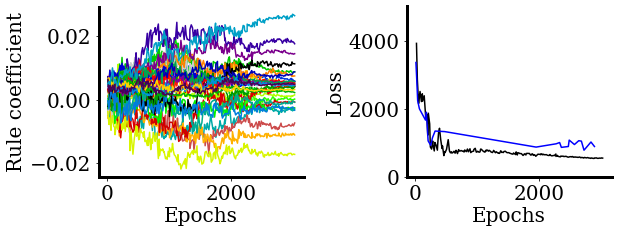

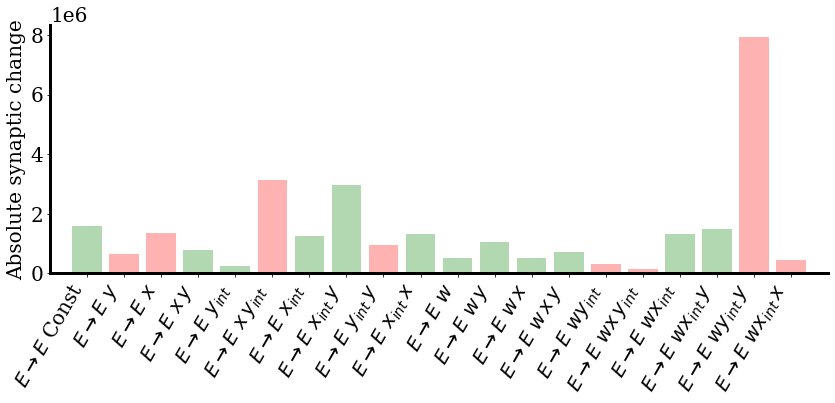

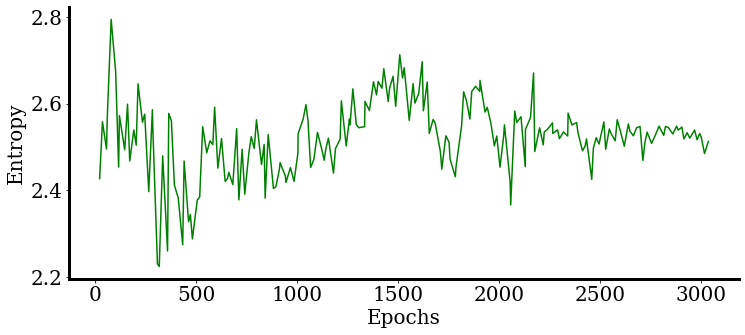

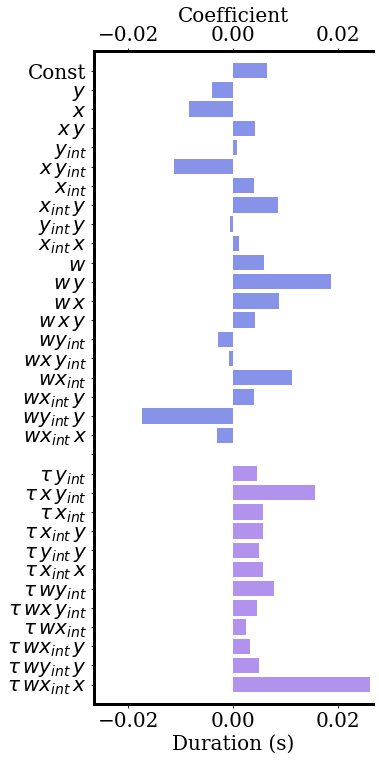

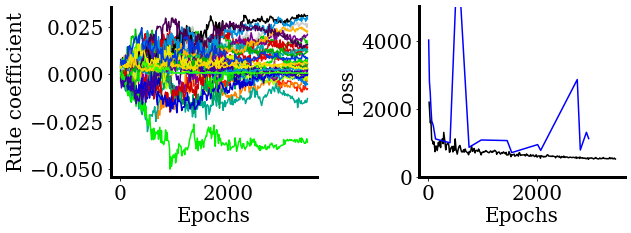

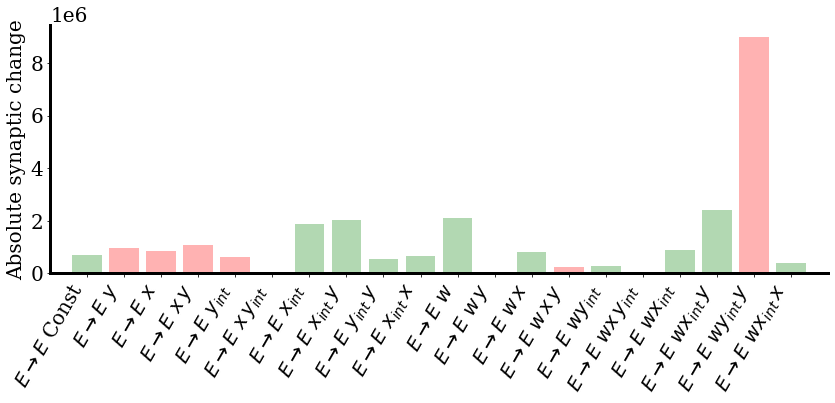

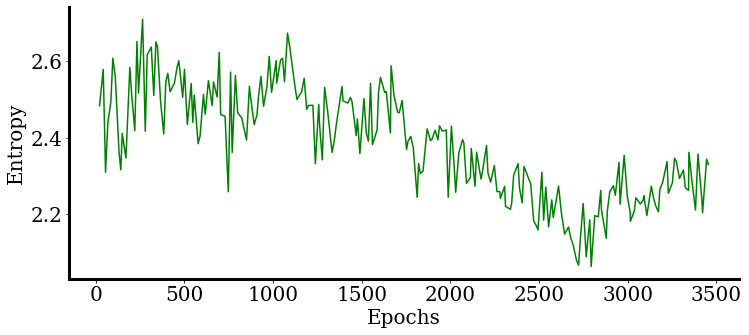

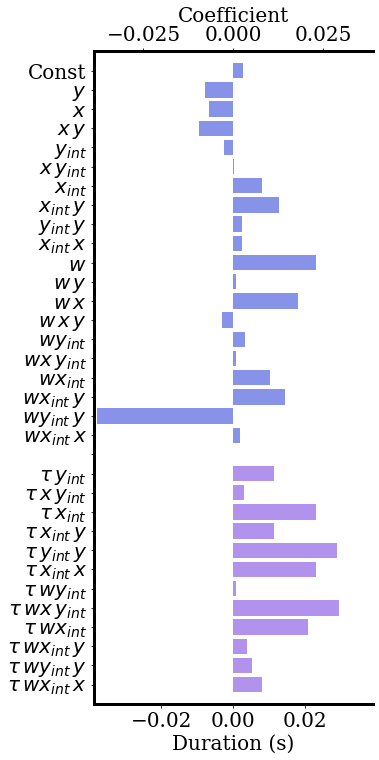

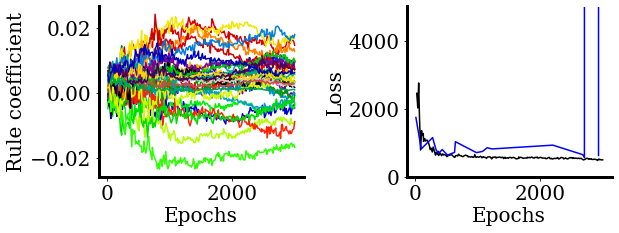

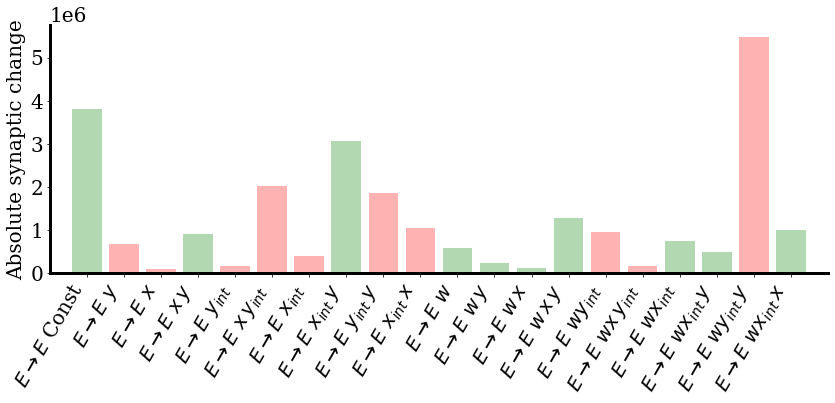

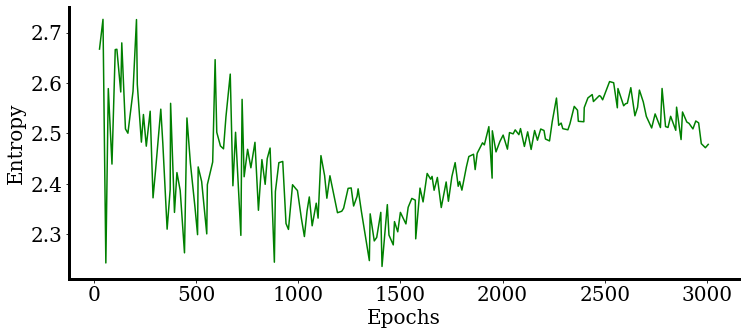

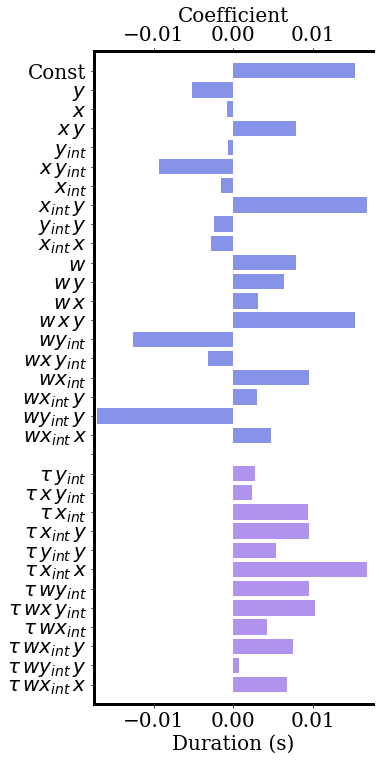

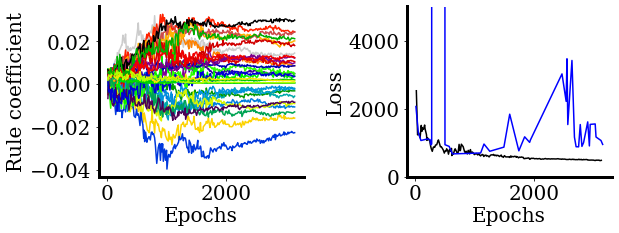

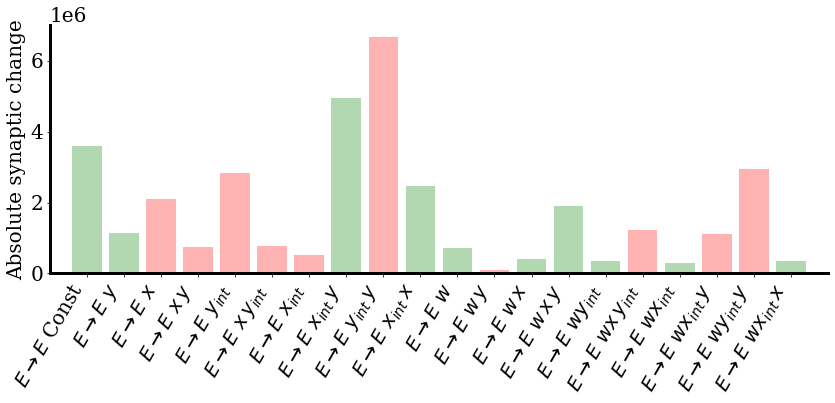

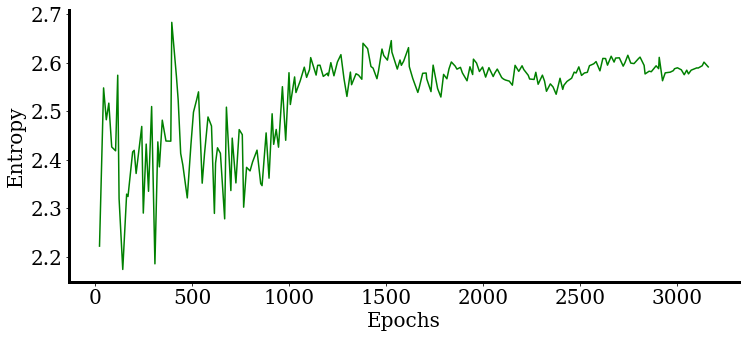

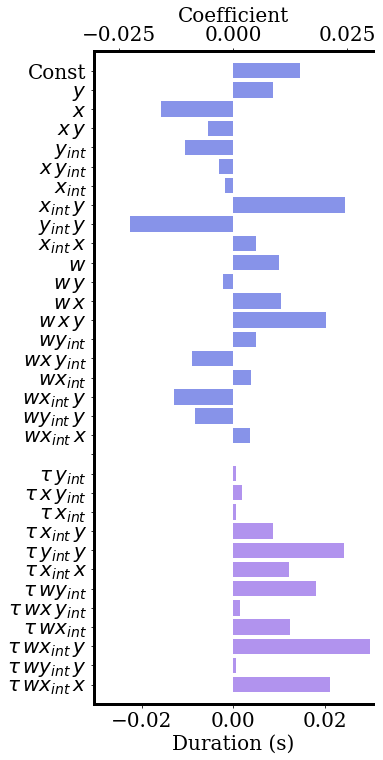

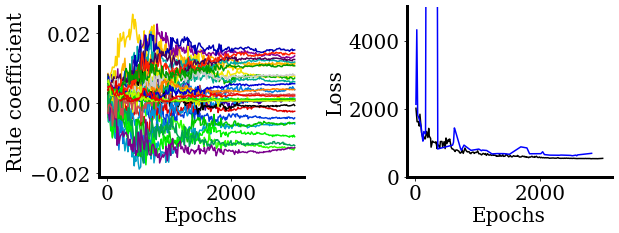

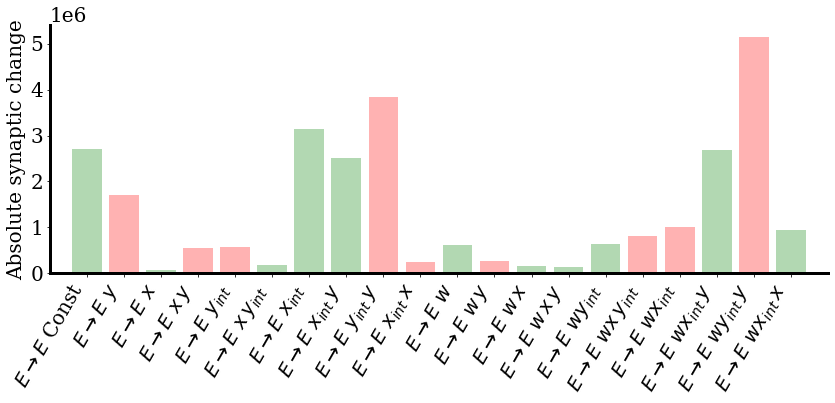

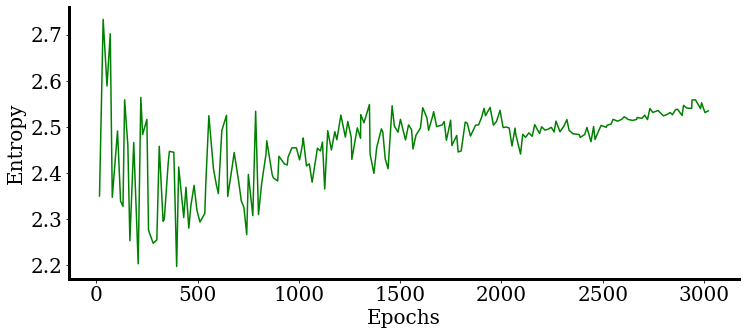

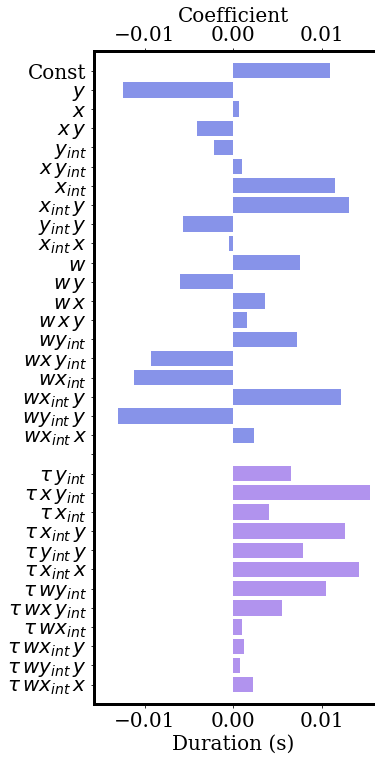

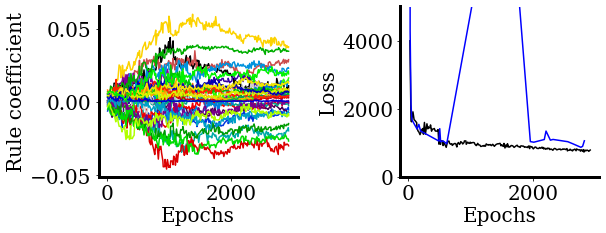

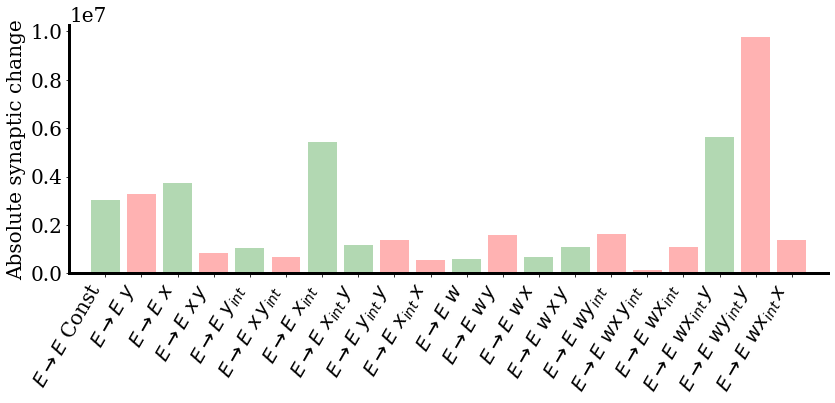

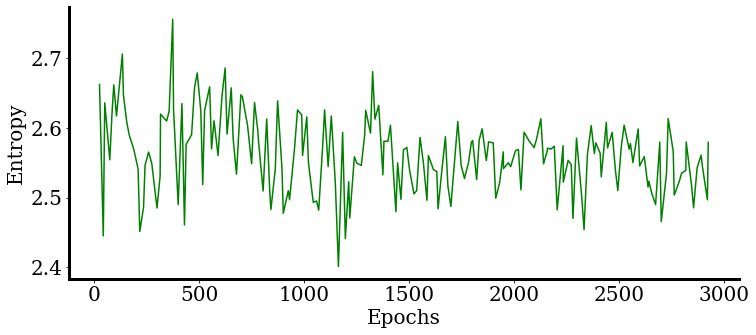

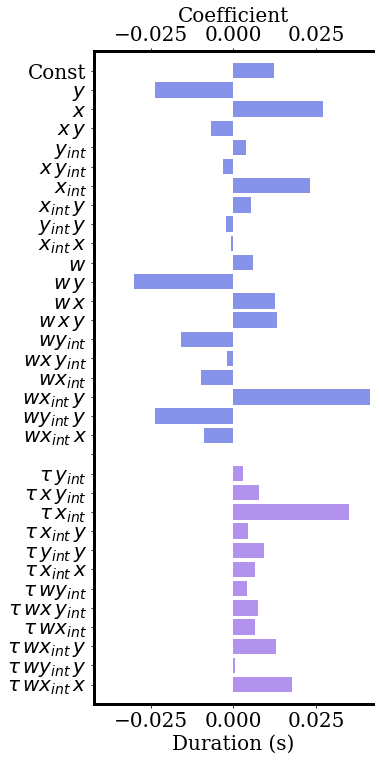

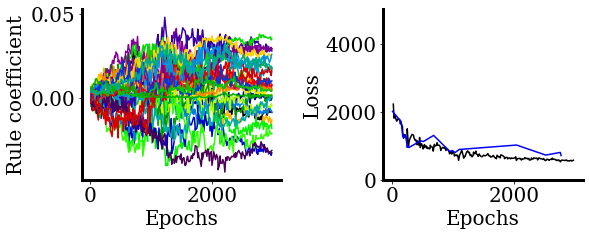

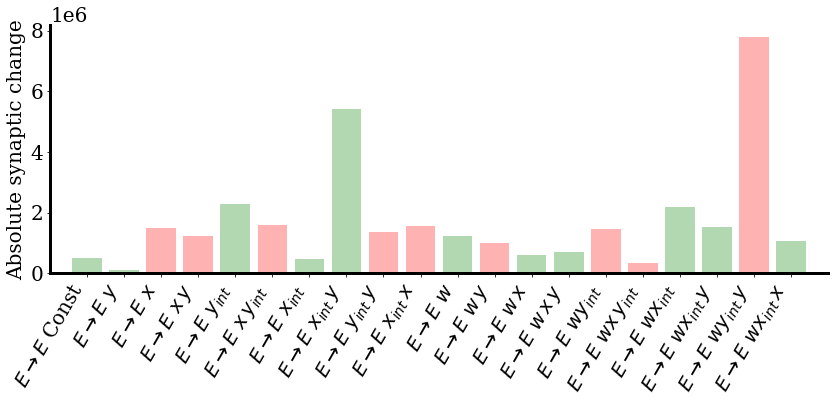

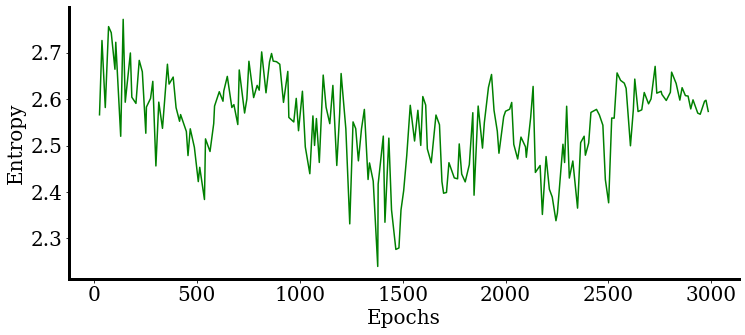

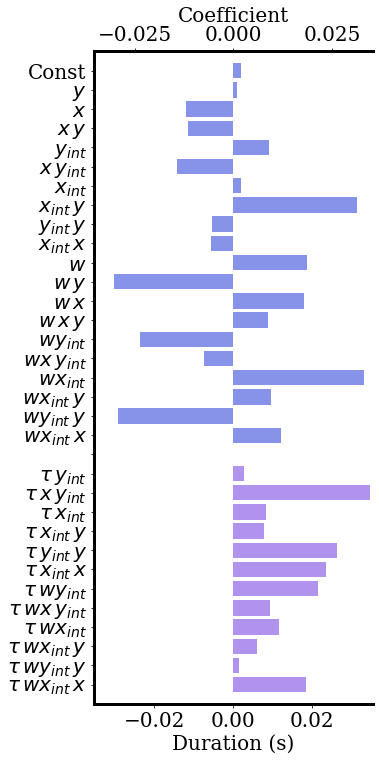

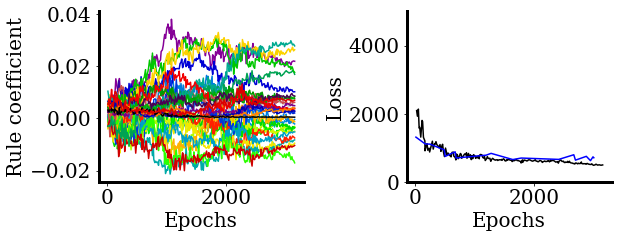

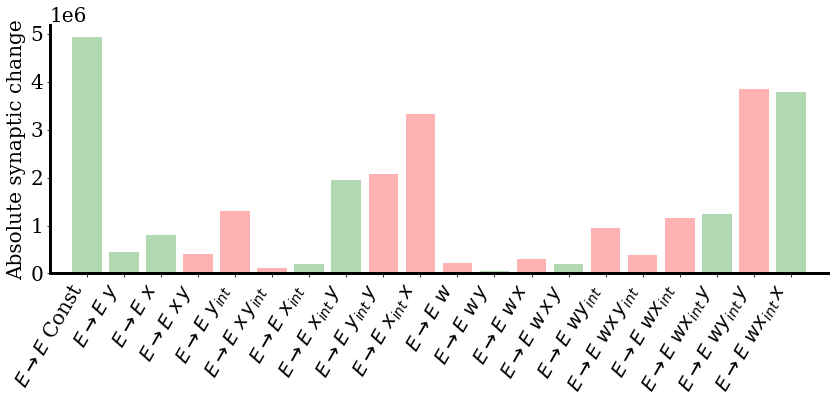

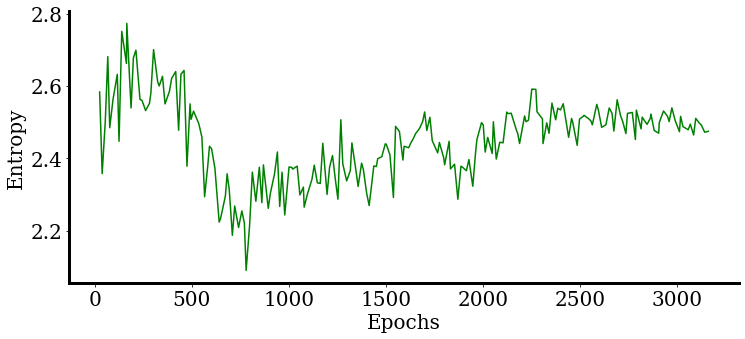

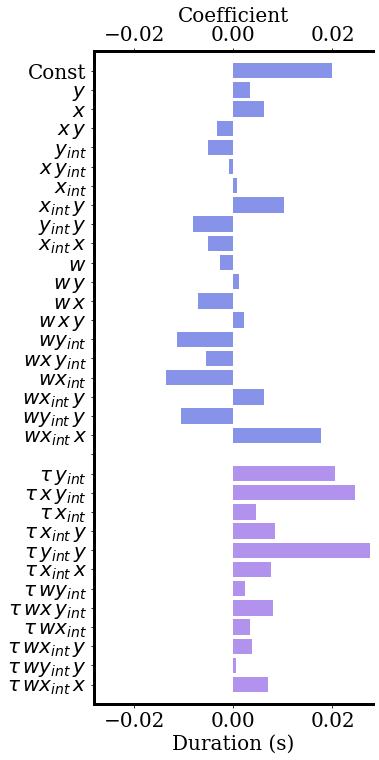

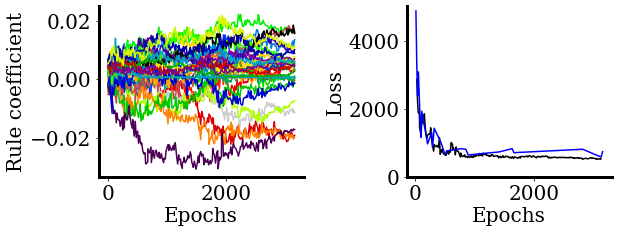

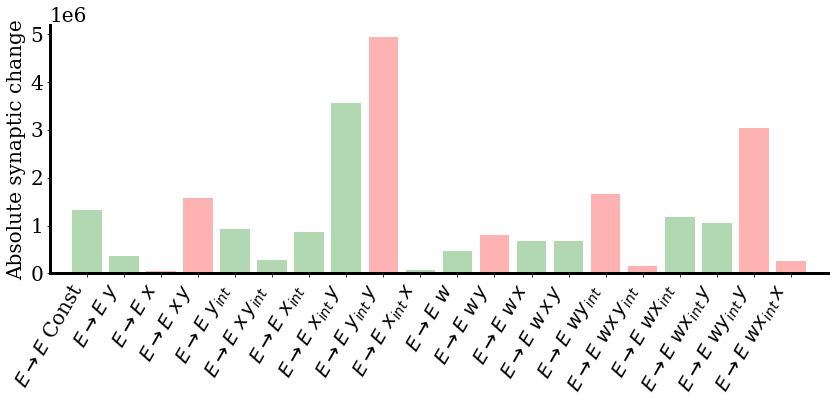

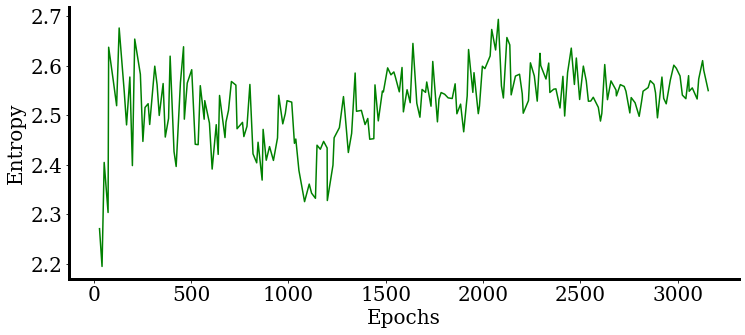

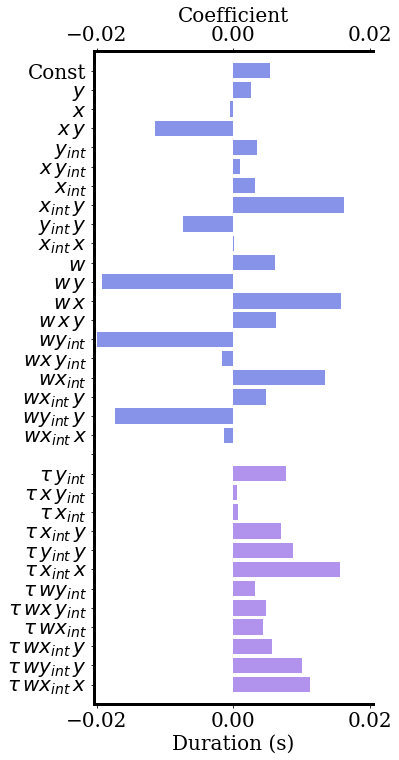

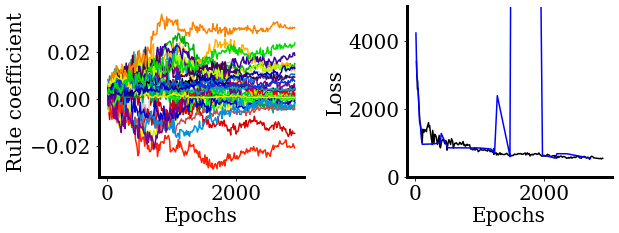

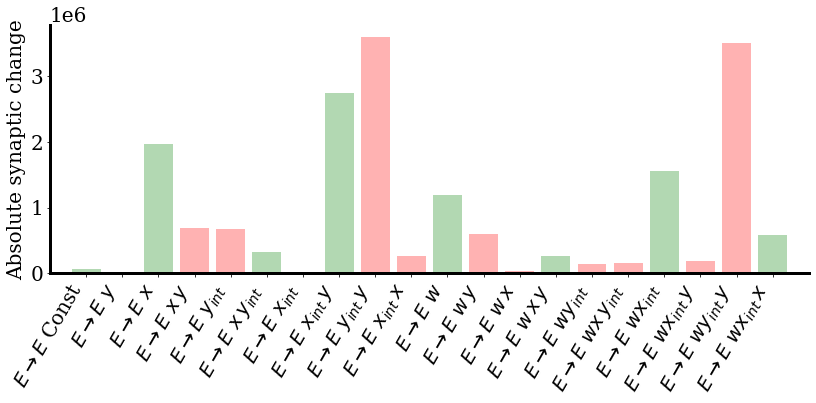

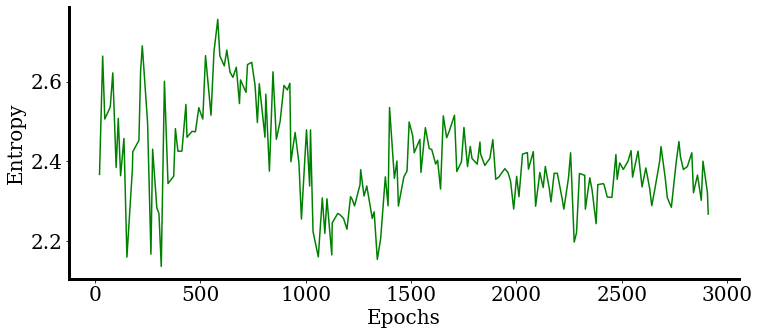

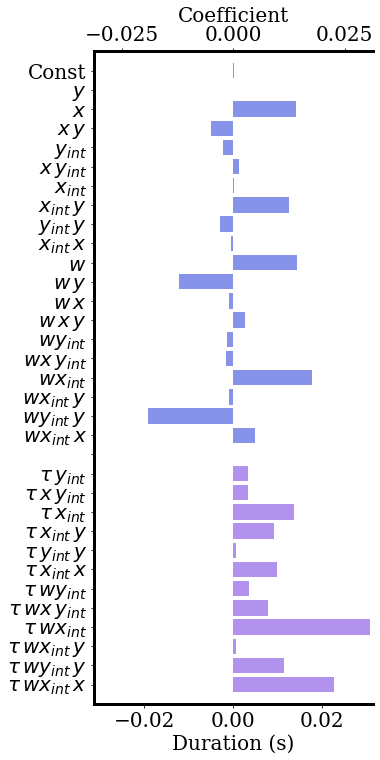

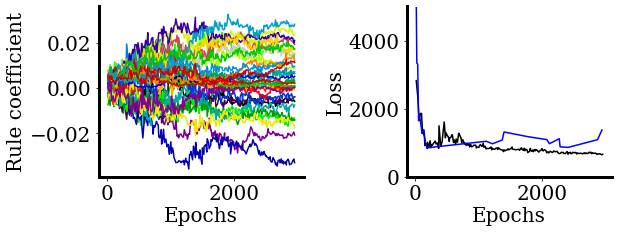

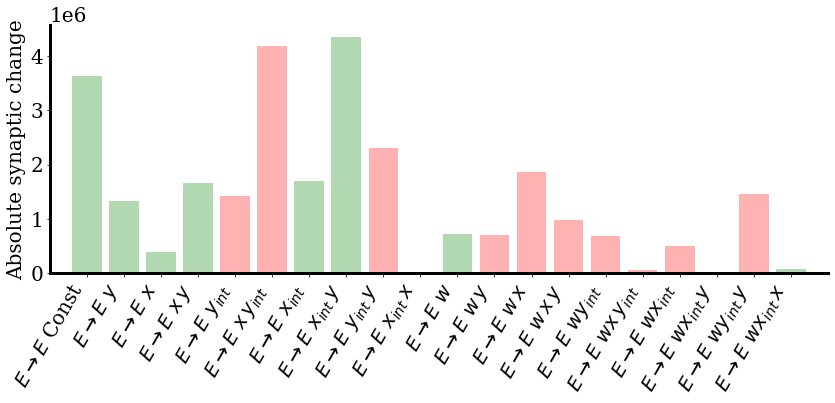

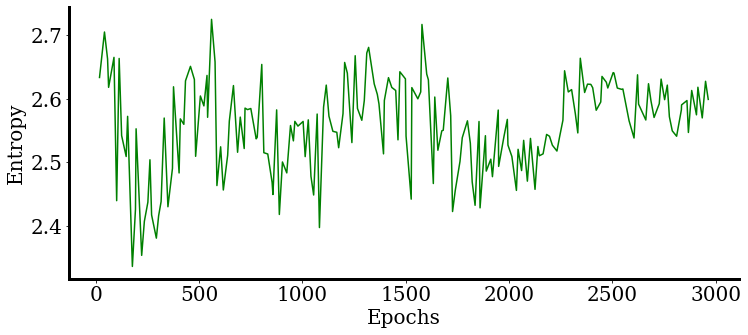

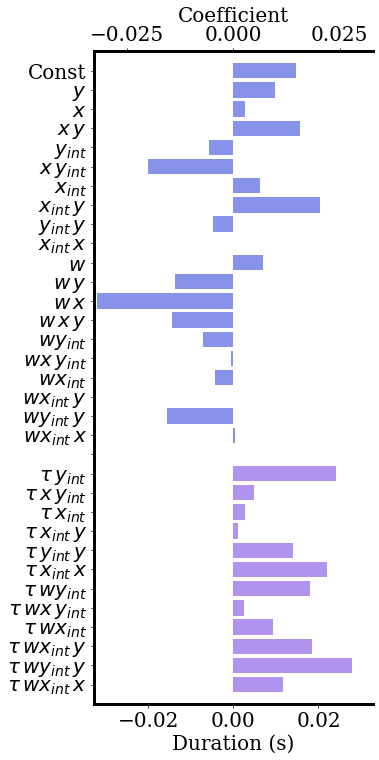

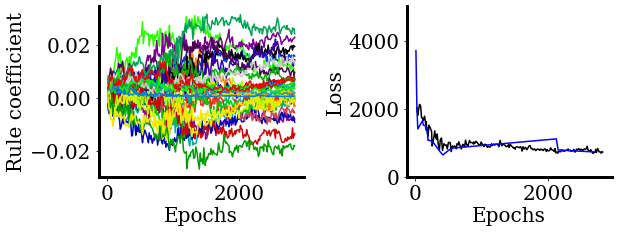

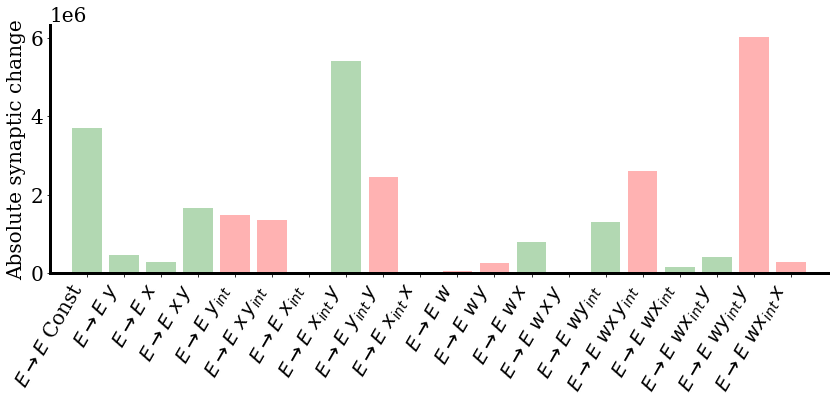

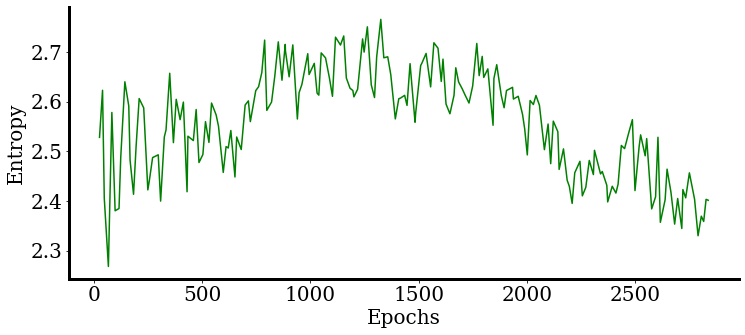

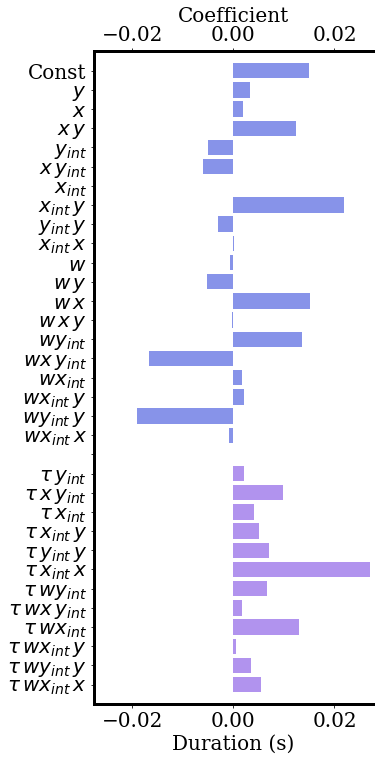

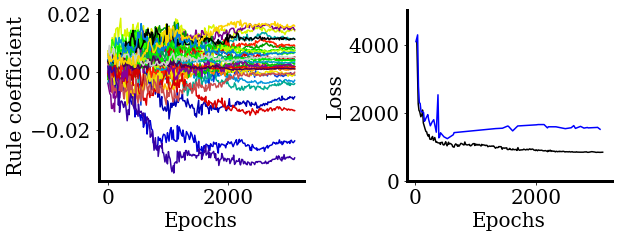

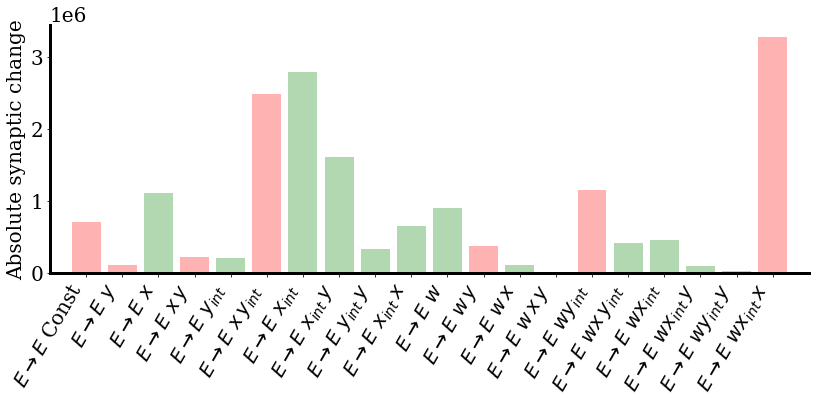

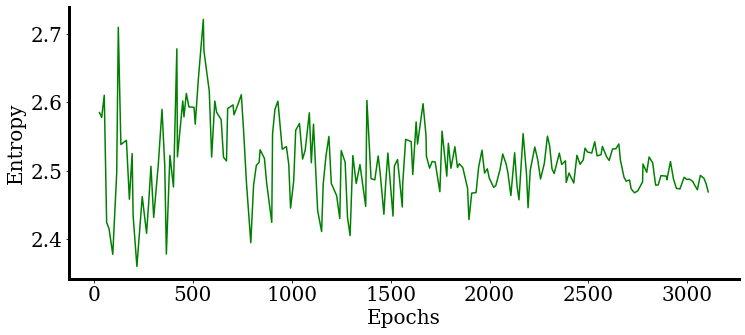

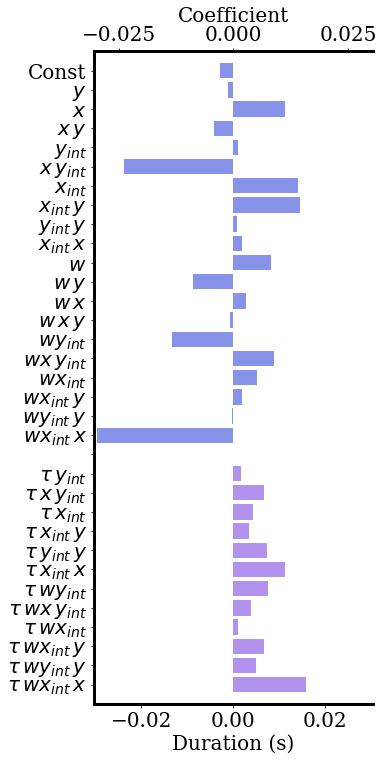

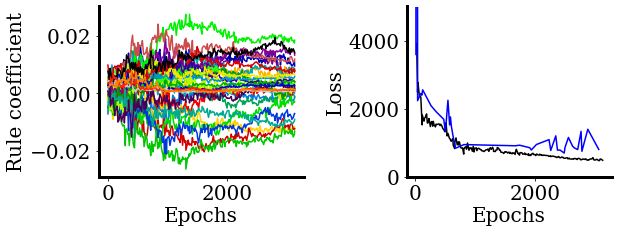

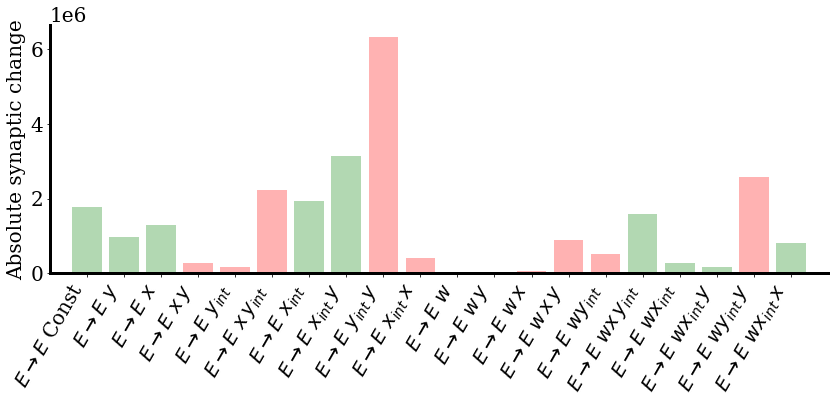

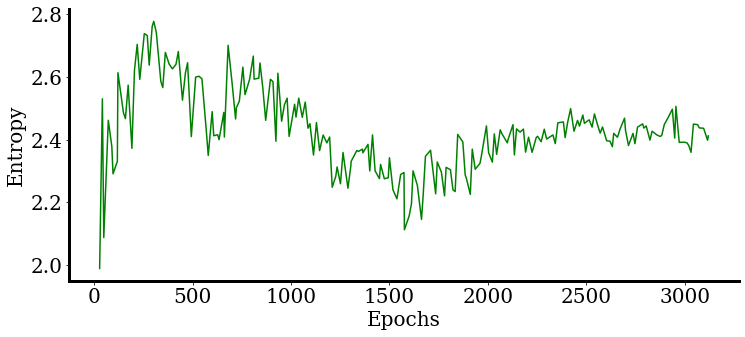

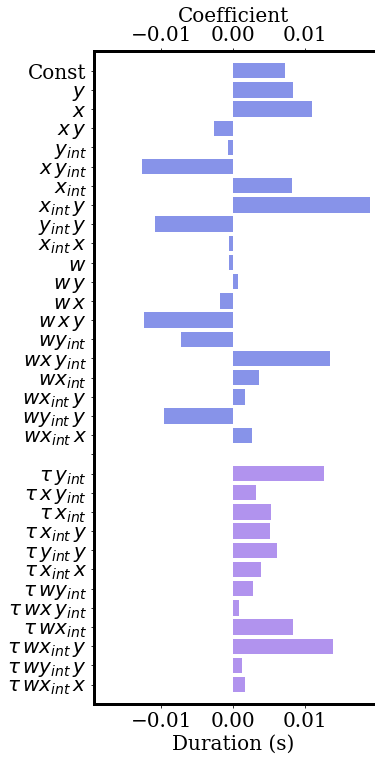

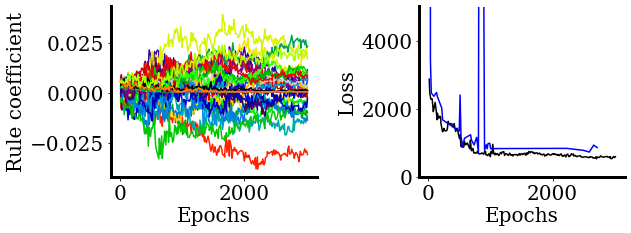

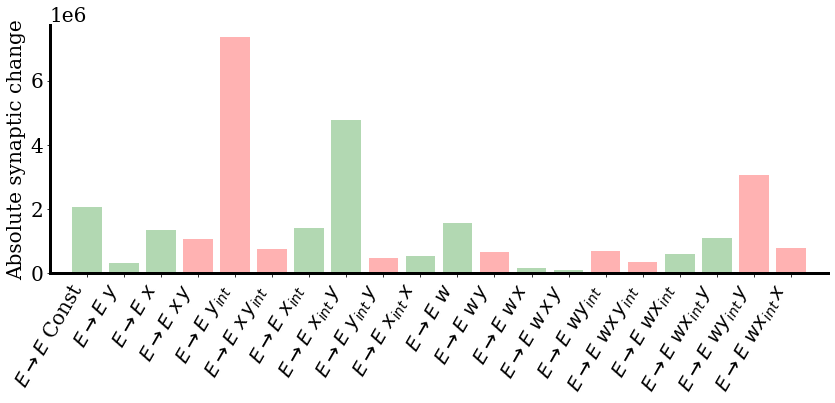

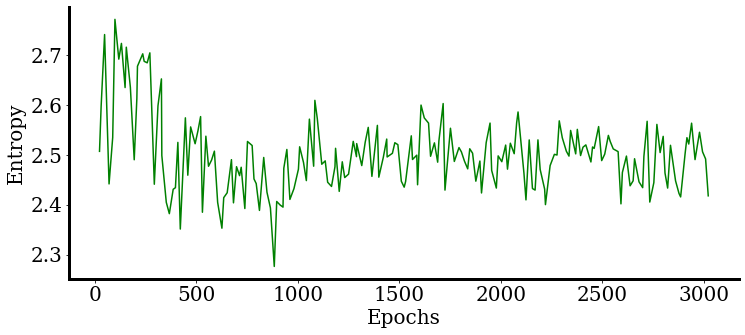

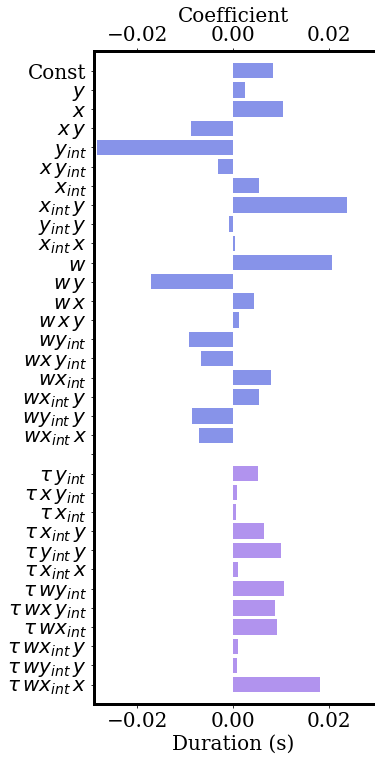

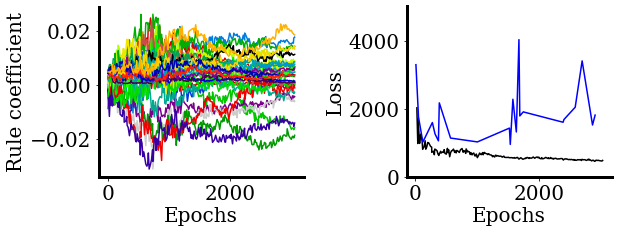

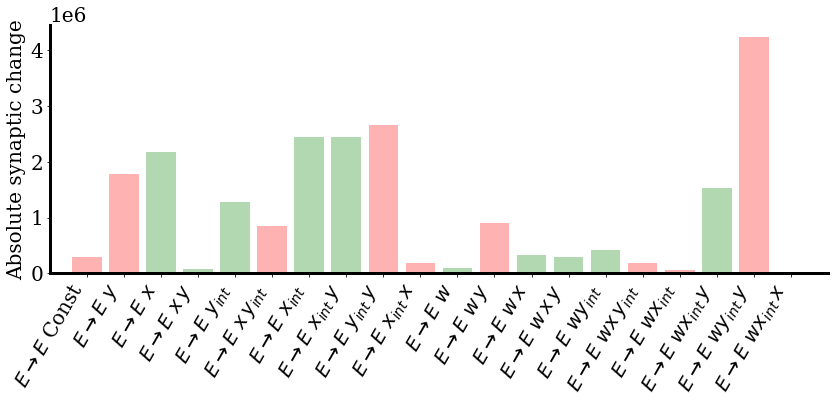

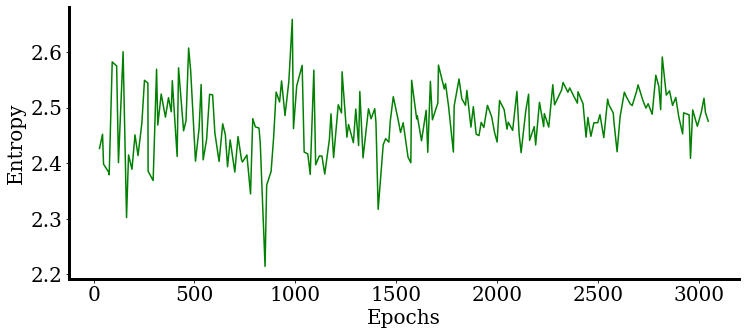

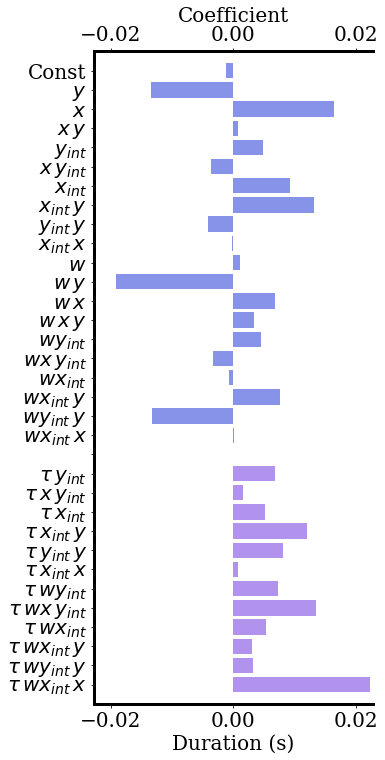

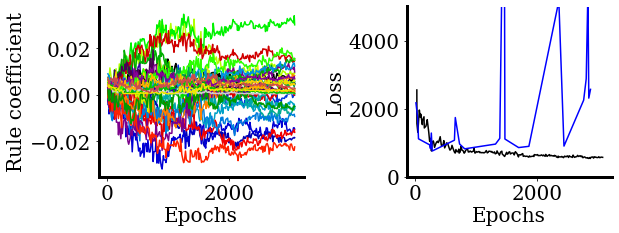

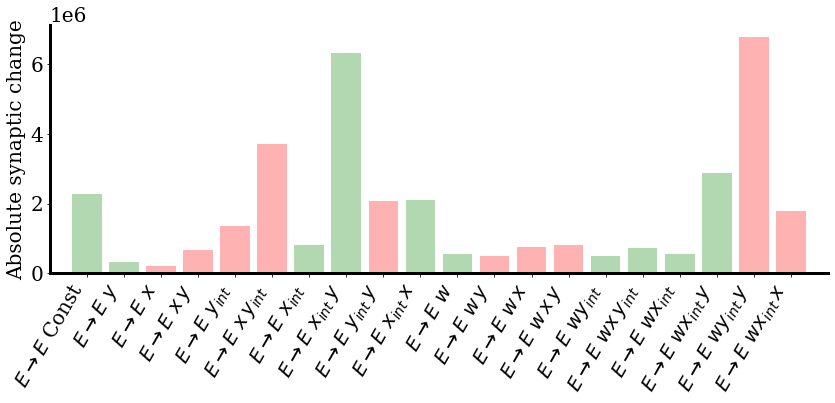

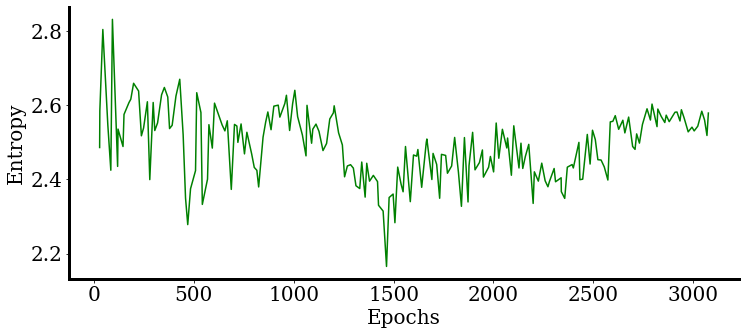

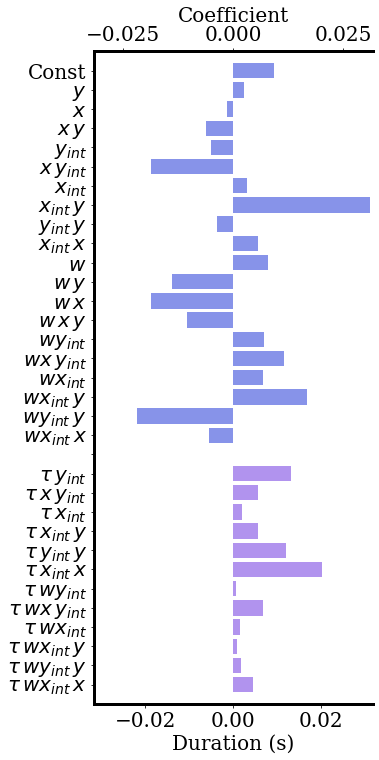

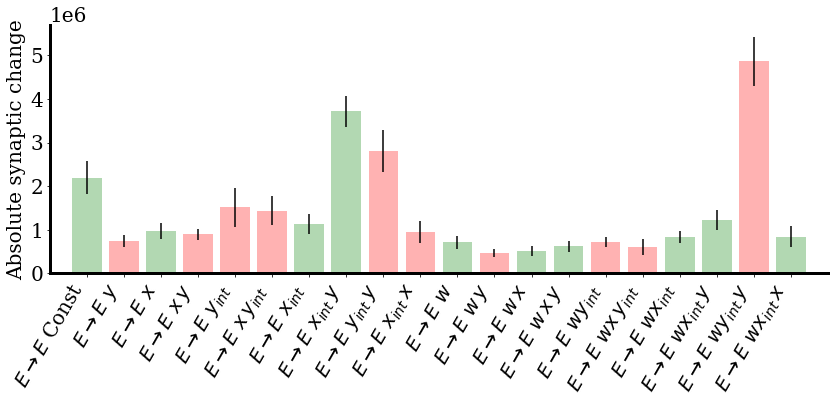

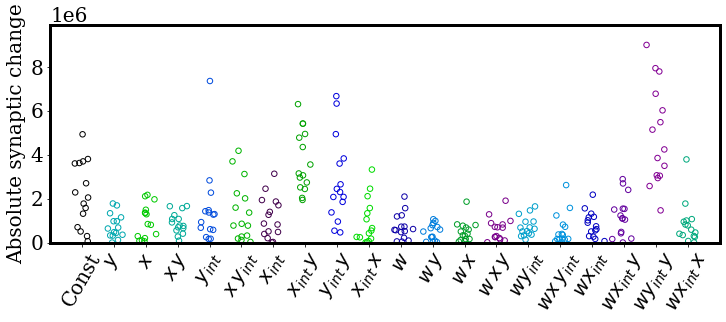

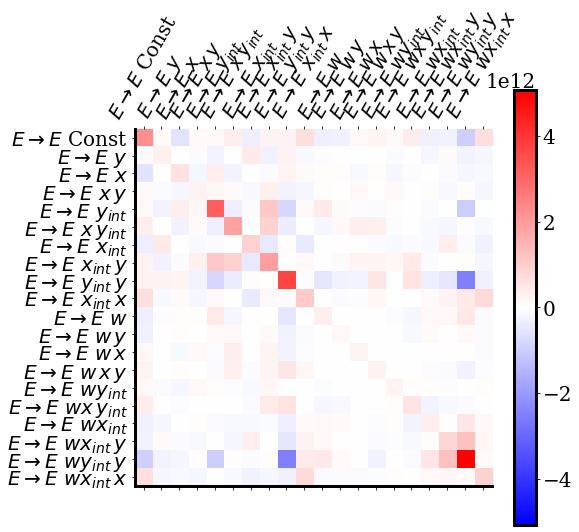

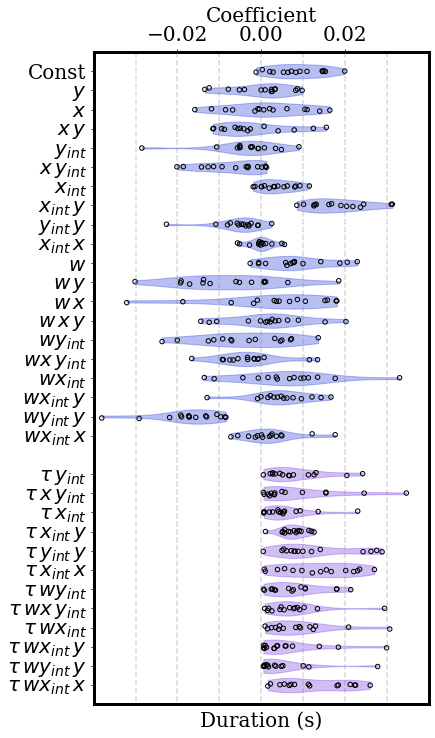

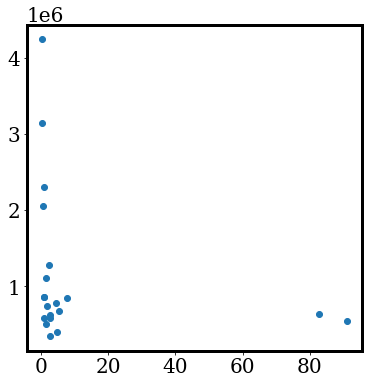

In [10]:
all_files = [
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8000_2023-12-26_11:28:08.640240',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8001_2023-12-26_12:45:57.120065',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8002_2023-12-26_12:45:57.080822',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8003_2023-12-26_12:45:57.086077',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8004_2023-12-26_13:35:32.813518',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8005_2024-03-28_18:43:33.573124',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8006_2024-03-28_20:48:12.711772',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8007_2024-03-29_13:24:09.853152',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8008_2024-03-29_15:38:45.274544',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8009_2024-04-17_18:00:57.874624',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8010_2024-04-17_20:40:33.402888',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8011_2024-04-17_20:40:34.652048',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8012_2024-04-17_20:40:09.093114',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8013_2024-04-18_07:34:58.286603',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8014_2024-04-18_07:36:54.011453',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8015_2024-04-18_08:26:55.376091',
    'decoder_ee_rollback_mixed_syn_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_8016_2024-04-18_08:33:28.930070',
]

plot_all_opt_runs(all_files, 20, 12, 10, l_thresh=700, n_categories=1, name='ee_perturbed')

# Evaluating learned rules against a test set and dropping out terms to determine importantance

In [20]:
def loss_violin_plots(file_names, n_plasticity_coefs, n_time_constants, batch_size, runs, n_categories=1, downsample_ratio=1):
    plt.rcParams['axes.linewidth'] = 3.0
    
    for file_name in file_names:
        figure_path = f'./figures/{file_name}'
        Path(figure_path).mkdir(parents=True, exist_ok=True)

        scale = 1.75
        gs = gridspec.GridSpec(7 * n_categories, 1)
        fig = plt.figure(figsize=(7 * scale, 2 * n_categories * scale), tight_layout=True)
        axs = []
        for i in range(n_categories):
            axs.append([fig.add_subplot(gs[i * 7: i * 7 + 2]), fig.add_subplot(gs[i * 7 + 2:i * 7 + 7])])

        cutoff = 400

        for ax in [axs]:
            ax[0][1].set_ylabel('Loss')
            ax[0][0].set_xticks([])
            ax[0][1].set_xticks(np.arange(n_plasticity_coefs + 1))
            ax[0][0].set_xticklabels([])
            ax[0][1].set_xticklabels(np.concatenate([['None'], general_rule_names[:n_plasticity_coefs]]), rotation=60, ha='right')

            ax[0][0].set_yscale('log')
            ax[0][0].set_ylim(cutoff * 0.1, 5e8)
            ax[0][0].set_yticks([1e3, 1e6, 1e9])
            ax[0][1].set_ylim(0, cutoff * 1.1)
            ax[0][0].set_xlim(-1, n_plasticity_coefs + 1)
            ax[0][1].set_xlim(-1, n_plasticity_coefs + 1)

#             ax[0][0].spines['bottom'].set_visible(False)
#             ax[0][0].spines['right'].set_visible(False)
#             ax[0][1].spines['top'].set_visible(False)
#             ax[0][1].spines['right'].set_visible(False)


        train_data_path = f'./sims_out/{file_name}/train_data.csv'
        df_train = read_csv(train_data_path, read_header=False, start=1)

        syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
        syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
        plasticity_coefs_start = 2 + batch_size
        plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

        losses = df_train[df_train.columns[1]]

        all_losses_for_dropouts = np.array([losses[i:i + runs] for i in range(0, (n_plasticity_coefs + 1) * runs, runs)])
        mean_losses_for_dropouts = np.array([np.mean(ls) for ls in all_losses_for_dropouts])
        std_losses_for_dropouts = np.array([np.std(ls) for ls in all_losses_for_dropouts])
        
        p_vals = []
        for k in range(0, n_plasticity_coefs + 1):
            res = stats.ttest_ind(all_losses_for_dropouts[k], all_losses_for_dropouts[0], equal_var=False)
            p_vals.append(res.pvalue)

        for i in range(0, (n_plasticity_coefs + 1) * runs, runs):
            idx = int(i/runs)
            losses_for_dropout = losses[i:i + runs]
            color = 'red' if p_vals[idx] < (0.05 / n_plasticity_coefs) else 'black'
                
            to_show_mask = np.zeros(runs).astype(bool)
            n_to_show = int(downsample_ratio * runs)
            to_show_mask[:n_to_show] = True
            
            losses_for_dropout_shown = losses_for_dropout[to_show_mask]
            under_cutoff_shown = losses_for_dropout_shown < cutoff
            under_cutoff = losses_for_dropout < cutoff
            losses_over_cutoff = losses_for_dropout[~under_cutoff]
            losses_under_cutoff = losses_for_dropout[under_cutoff]
            losses_over_cutoff_shown = losses_for_dropout_shown[~under_cutoff_shown]
            losses_under_cutoff_shown = losses_for_dropout_shown[under_cutoff_shown]
            
            if len(losses_under_cutoff) > 0:
                violin_parts = axs[0][1].violinplot(losses_under_cutoff, widths=0.75, showmeans=False, showextrema=False, positions=[idx])
                for pc in violin_parts['bodies']:
                    pc.set_color(color)
    
    
            axs[0][0].scatter((np.ones(len(losses_over_cutoff_shown)) * idx + np.random.normal(size=len(losses_over_cutoff_shown), scale=0.15)),
                        losses_over_cutoff_shown, marker='o', facecolor='none', edgecolor=color)
            axs[0][1].scatter((np.ones(len(losses_under_cutoff_shown)) * idx + np.random.normal(size=len(losses_under_cutoff_shown), scale=0.15)),
                        losses_under_cutoff_shown, marker='o', facecolor='none', edgecolor=color)
            
        axs[0][1].set_xlabel('Dropped term')

        fig.savefig(os.path.join(figure_path, 'rule_perturbation.png'))
        fig.savefig(os.path.join(figure_path, 'rule_perturbation.svg'))

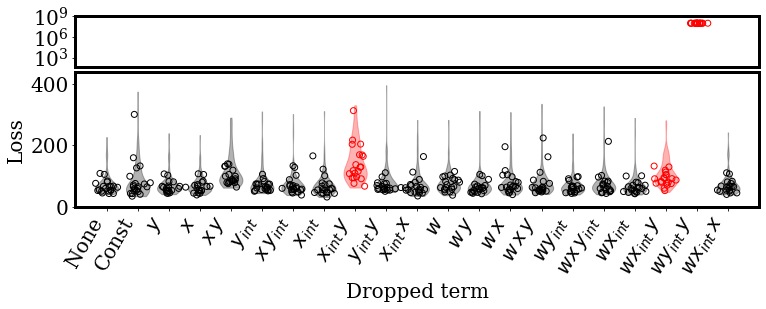

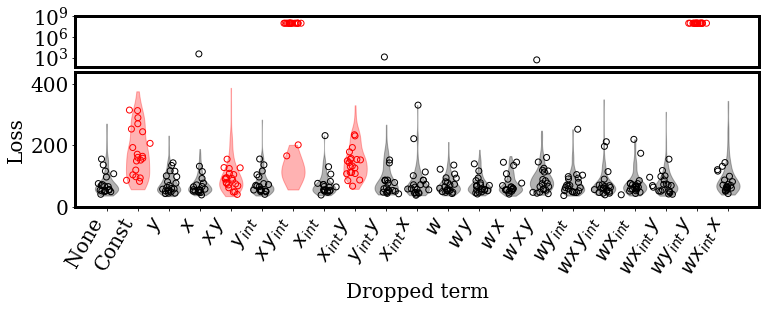

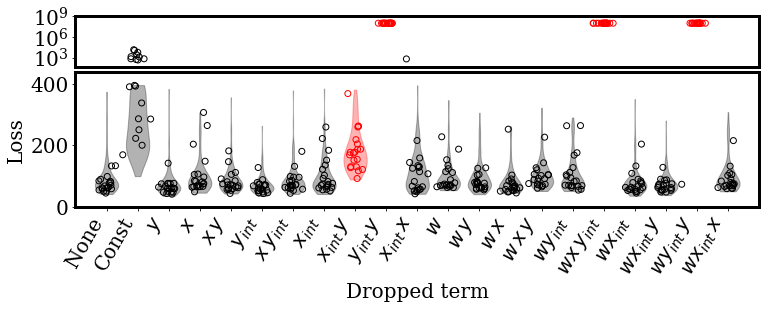

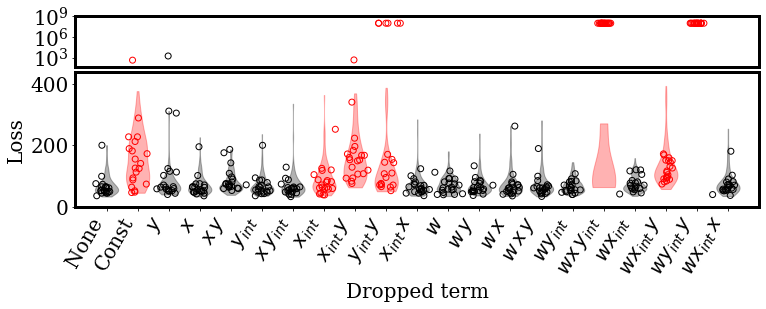

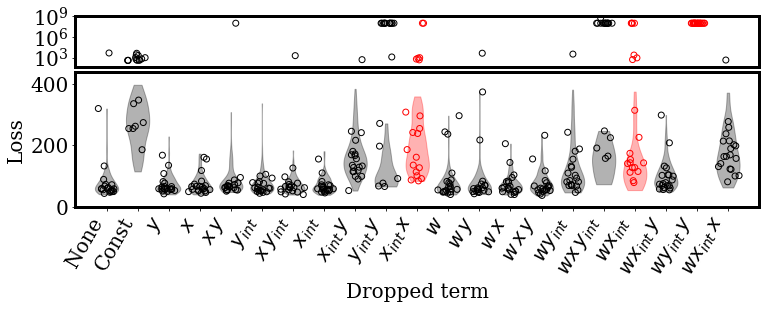

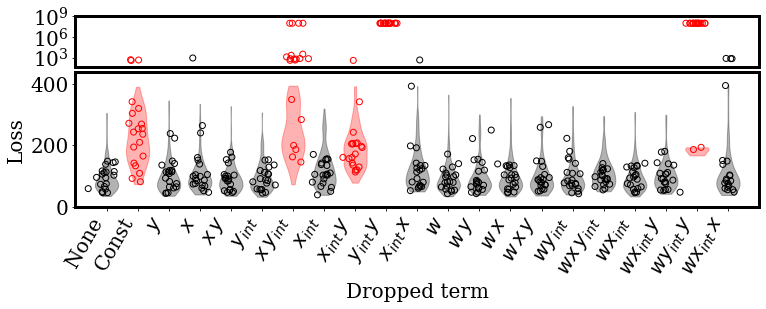

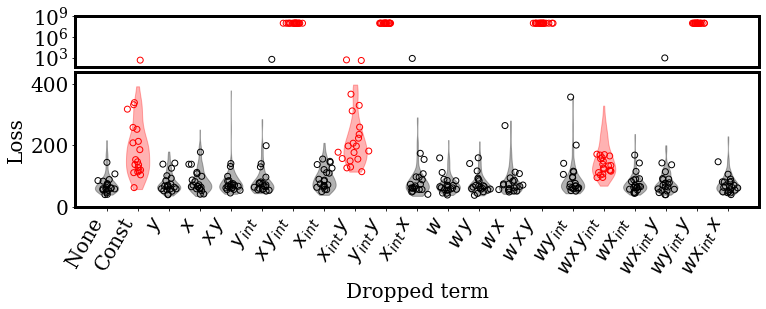

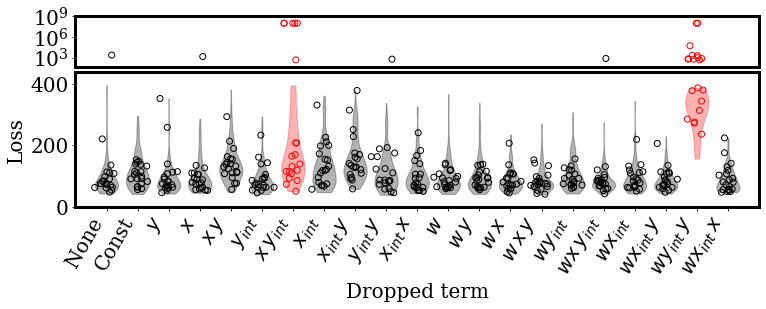

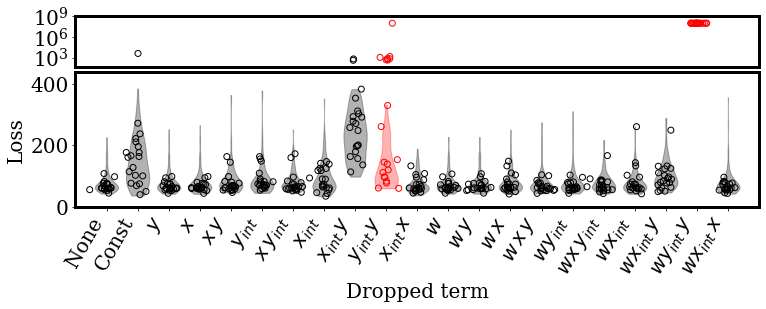

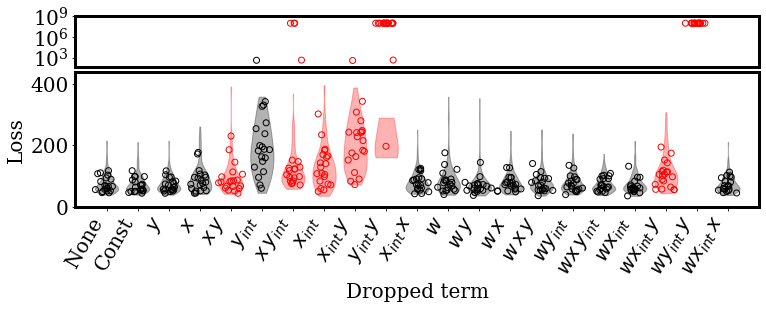

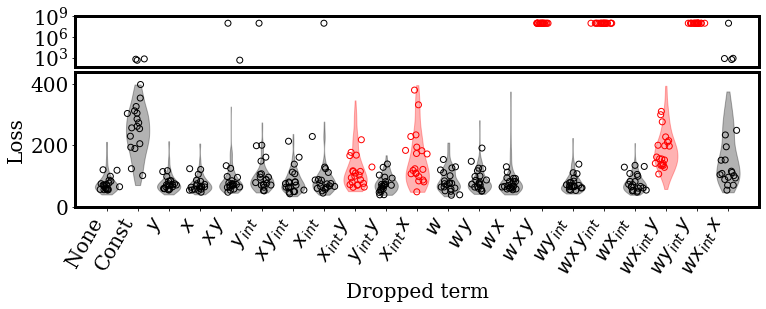

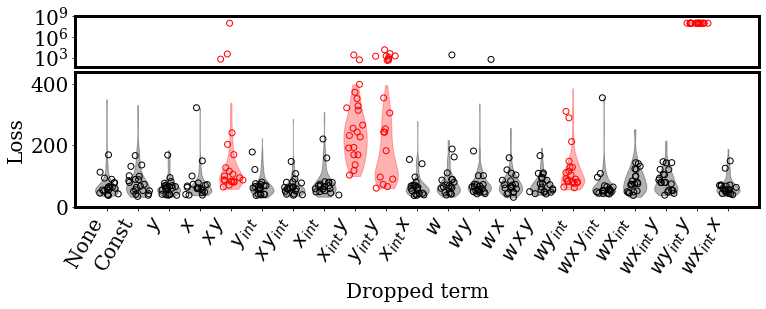

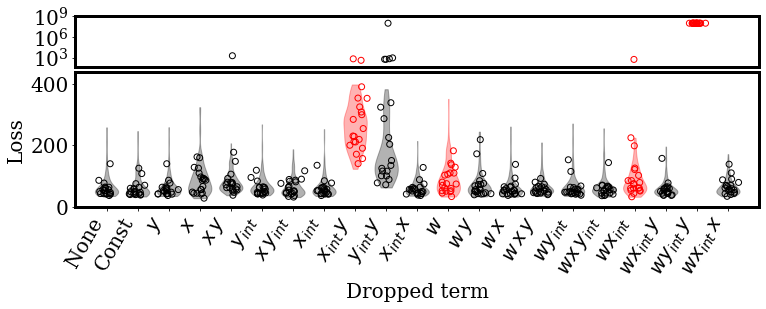

In [21]:
file_names = [
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-29_23:01:37.635979',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_00:01:42.060343',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_00:10:47.409233',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_03:27:21.936367',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_04:29:42.120501',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_04:49:27.258787',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_09:25:44.617758',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_10:24:41.620714',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:17:00.369243',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:17:01.082174',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:17:29.879988',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:17:29.896900',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:19:28.789082',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:50:05.281322',
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-05-02_13:22:45.473420',
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-05-02_15:01:16.905423',
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-05-02_15:01:16.911429',
]
loss_violin_plots(file_names, 20, 12, 1, 100, n_categories=1, downsample_ratio=0.2)

# Ordering terms by KL divergence between dropped term case and null case

Here, we use the KL divergence between the dropout test cases and the no-dropout case to determine a heirarchy of term importance. 

In [17]:
def compute_kl_divs(file_name, n_plasticity_coefs, n_time_constants, batch_size, runs, n_categories=1):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)        
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    df_train = read_csv(train_data_path, read_header=False, start=1)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    
    coefs = []
    for i in range(plasticity_coefs_start, plasticity_coefs_end):
        coefs.append(df_train[df_train.columns[i]][0])    
    
    all_losses_for_dropouts = np.array([losses[i:i + runs] for i in range(0, (n_plasticity_coefs + 1) * runs, runs)])
#     print(all_losses_for_dropouts)
    
    max_loss, min_loss = (2e8, 0)
    bins = np.power(1.2, np.arange(100))
    bins = (max_loss - min_loss) * (bins - bins.min()) / (bins - bins.min()).max() + min_loss
    
    null_dist, _ = np.histogram(all_losses_for_dropouts[0, :], bins=bins, density=True)
    
    kl_divs = []

    epsilon = 1e-10    
    
    for d_idx in np.arange(1, all_losses_for_dropouts.shape[0]):
        term_dropped_dist, _ = np.histogram(all_losses_for_dropouts[d_idx, :], bins=bins, density=True)
        
        if np.isnan(term_dropped_dist).any():
            print(term_dropped_dist)
            print(all_losses_for_dropouts[d_idx, :])
        
        kl_divergence = np.sum((null_dist + epsilon) * np.log((null_dist + epsilon) / (term_dropped_dist + epsilon)))
        
        kl_divs.append(kl_divergence)
        
    return np.array(kl_divs), np.mean(all_losses_for_dropouts[0])

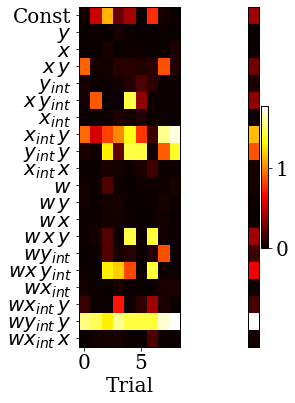

In [19]:
file_names = [
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-29_23:01:37.635979',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_00:01:42.060343',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_00:10:47.409233',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_03:27:21.936367',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_04:29:42.120501',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_04:49:27.258787',
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_07:47:09.504753',
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_08:40:37.239915',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_09:25:44.617758',
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_10:18:54.727989',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_10:24:41.620714',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:17:00.369243',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:17:01.082174',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:17:29.879988',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:17:29.896900',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:19:28.789082',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:50:05.281322',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-05-02_13:22:45.473420',
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-05-02_15:01:16.905423',
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-05-02_15:01:16.911429',
]

plt.rcParams['axes.linewidth'] = 1

all_kl_divs = []
for file_name in file_names:
    kl_divs, mean_non_dropped_loss = compute_kl_divs(file_name, 20, 12, 1, 100, n_categories=1)
    if mean_non_dropped_loss < 100:
#         print(kl_divs)
        all_kl_divs.append(kl_divs)

all_kl_divs = np.array(all_kl_divs)
# all_kl_divs = np.concatenate([all_kl_divs, all_kl_divs.mean(axis=0).reshape(1, all_kl_divs.shape[1])])

scale = 3
gs = gridspec.GridSpec(1, 10)
fig = plt.figure(figsize=(1.5 * scale, 2 * scale), tight_layout=False)
axs = [fig.add_subplot(gs[:7]), fig.add_subplot(gs[7:])]

cbar = axs[0].imshow(all_kl_divs.T, aspect=1.5, cmap='hot')

axs[1].imshow(np.mean(all_kl_divs.T, axis=1).reshape(all_kl_divs.shape[1], 1), aspect=1.5, cmap='hot')

fig.colorbar(cbar, ax=axs[1])


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,  # labels along the bottom edge are off
    labeltop=False)

# plt.tick_params(
#     axis='y',          # changes apply to the y-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False, # labels along the bottom edge are off
#     labeltop=False)

# axs.set_xticks([])
# axs.set_xticklabels([])
axs[0].set_yticks(np.arange(all_kl_divs.shape[1]))
axs[0].set_yticklabels(general_rule_names[:all_kl_divs.shape[1] + 1], rotation=0, ha='right')
axs[0].set_xlabel('Trial')
axs[1].set_xticks([])
axs[1].set_xticklabels([])
axs[1].set_yticks([])
axs[1].set_yticklabels([])

fig.savefig('./figures/decoder_ee_perturbed_kl_div_loss.png')
fig.savefig('./figures/decoder_ee_perturbed_kl_div_loss.svg')

In [33]:
def compute_loss_shifts(file_name, n_plasticity_coefs, n_time_constants, batch_size, runs, n_categories=1):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)        
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    df_train = read_csv(train_data_path, read_header=False, start=1)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    coefs = df_train[df_train.columns[plasticity_coefs_start:plasticity_coefs_end]].iloc[0].to_numpy()
    
    all_losses_for_dropouts = np.array([losses[i:i + runs] for i in range(0, (n_plasticity_coefs + 1) * runs, runs)])
    
    kl_divs = []
    for d_idx in np.arange(1, all_losses_for_dropouts.shape[0]):
        kl_divergence = np.maximum(np.median(all_losses_for_dropouts[d_idx, :]) - np.median(all_losses_for_dropouts[0, :]), 0)
        kl_divs.append(kl_divergence)
        
    return np.array(kl_divs), np.mean(all_losses_for_dropouts[0]), coefs

0.00612355211685744 75.70938177590752
0.011001647134089156 71.92224299274294
0.012494620404043219 76.14190589862514
0.021289919218589477 94.32780437593723
0.011348806980913366 70.50817569878984
0.02289246674192853 122.5513416702929
0.007705852567793598 104.07484696653393
0.01345981414817357 81.4664471577598
0.002724434022895225 114.1541908183877
-0.0014360878548555739 75.88214630720678
0.012948324837681649 77.49764604575009
0.005562827569675955 72.44857768205965
0.0002659520686658541 64.55959997696053
13
[1.10991784e+02 1.10498767e+00 6.16427267e+00 1.68448223e+01
 1.26322007e+01 2.33855265e+07 1.40584523e+01 1.07751756e+02
 3.89539182e+07 2.87756512e+01 5.60504856e+00 2.65126243e+00
 1.71569499e+00 1.55745824e+07 7.84999825e+00 3.11647019e+07
 1.52166177e+01 2.34353150e+01 9.34678161e+07 1.99767256e+01]


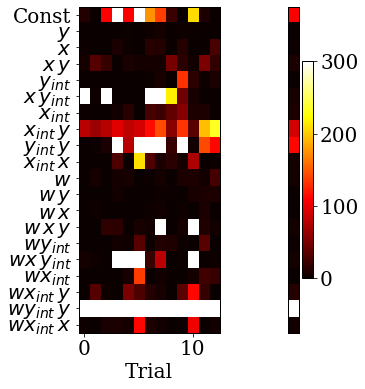

In [49]:
file_names = [
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-29_23:01:37.635979',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_00:01:42.060343',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_00:10:47.409233',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_03:27:21.936367',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_04:29:42.120501',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_04:49:27.258787',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_09:25:44.617758',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_10:24:41.620714',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:17:00.369243',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:17:01.082174',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:17:29.879988',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:17:29.896900',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:19:28.789082',
    'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-04-30_12:50:05.281322',
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-05-02_13:22:45.473420',
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-05-02_15:01:16.905423',
#     'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2024-05-02_15:01:16.911429',
]

plt.rcParams['axes.linewidth'] = 1

all_kl_divs = []
leading_coefs = []
for file_name in file_names:
    kl_divs, mean_non_dropped_loss, coefs = compute_loss_shifts(file_name, 20, 12, 1, 100, n_categories=1)
    if mean_non_dropped_loss < 150:
        print(coefs[0], mean_non_dropped_loss)
        all_kl_divs.append(kl_divs)
        leading_coefs.append(coefs[0])
        


print(len(all_kl_divs))
all_kl_divs = np.array(all_kl_divs)
# all_kl_divs = np.concatenate([all_kl_divs, all_kl_divs.mean(axis=0).reshape(1, all_kl_divs.shape[1])])

scale = 3
gs = gridspec.GridSpec(1, 10)
fig = plt.figure(figsize=(1.5 * scale, 2 * scale), tight_layout=False)
axs = [fig.add_subplot(gs[:7]), fig.add_subplot(gs[7:])]

cbar = axs[0].imshow(all_kl_divs.T, aspect=1.5, cmap='hot', vmin=0, vmax=300)

print(np.mean(all_kl_divs.T, axis=1))
axs[1].imshow(np.median(all_kl_divs.T, axis=1).reshape(all_kl_divs.shape[1], 1), aspect=1.5, cmap='hot', vmin=0, vmax=300)

fig.colorbar(cbar, ax=axs[1])


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,  # labels along the bottom edge are off
    labeltop=False)

# plt.tick_params(
#     axis='y',          # changes apply to the y-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False, # labels along the bottom edge are off
#     labeltop=False)

# axs.set_xticks([])
# axs.set_xticklabels([])
axs[0].set_yticks(np.arange(all_kl_divs.shape[1]))
axs[0].set_yticklabels(general_rule_names[:all_kl_divs.shape[1] + 1], rotation=0, ha='right')
axs[0].set_xlabel('Trial')
axs[1].set_xticks([])
axs[1].set_xticklabels([])
axs[1].set_yticks([])
axs[1].set_yticklabels([])

fig.savefig('./figures/decoder_ee_perturbed_median_loss.png')
fig.savefig('./figures/decoder_ee_perturbed_median_loss.svg')

# Building the model progressively to determine terms of true importance

In [4]:
def fetch_minimum_loss(file_name, n_plasticity_coefs, n_time_constants, batch_size, n_categories=1):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)        
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    test_data_path = f'./sims_out/{file_name}/test_data.csv'
    df_train = read_csv(train_data_path, read_header=False, start=1)
    df_test = read_csv(test_data_path, read_header=False, start=1)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    min_loss_idx = df_train[df_train.columns[0]][np.argmin(losses)]
    
    losses_test = df_test[df_test.columns[1]]
    
    return np.min(losses), np.min(losses_test)

Text(0.5, 0, 'No. terms included')

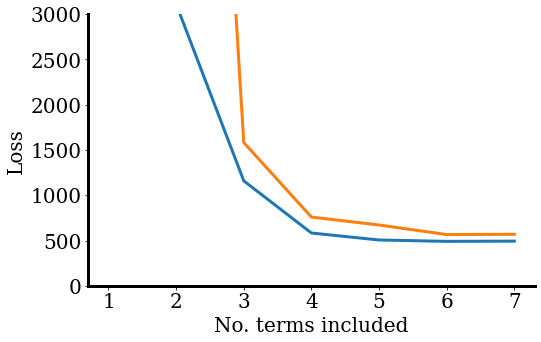

In [17]:
file_names = [
    'refit_ee_pert_median_1_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-06_15:39:48.347133',
    'refit_ee_pert_median_2_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-07_01:54:13.043861',
    'refit_ee_pert_median_3_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-06_15:39:48.203085',
    'refit_ee_pert_median_4_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-06_15:40:47.728457',
    'refit_ee_pert_median_5_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-07_06:40:25.191402',
    'refit_ee_pert_median_6_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-07_11:41:07.083642',
    'refit_ee_pert_median_7_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-07_12:34:05.668599',
]

plt.rcParams['axes.linewidth'] = 3.0

all_losses = []
all_losses_test = []
for f in file_names:
    min_loss, min_loss_test = fetch_minimum_loss(f, 20, 12, 10)
    all_losses.append(min_loss)
    all_losses_test.append(min_loss_test)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 2.5 * scale))
format_axs(axs)

axs.plot(np.arange(1, 8), all_losses, lw=3)
axs.plot(np.arange(1, 8), all_losses_test, lw=3)
# axs.set_yscale('log')
axs.set_ylim(0, 3000)
axs.set_ylabel('Loss')
axs.set_xlabel('No. terms included')

Text(0.5, 0, 'No. terms included')

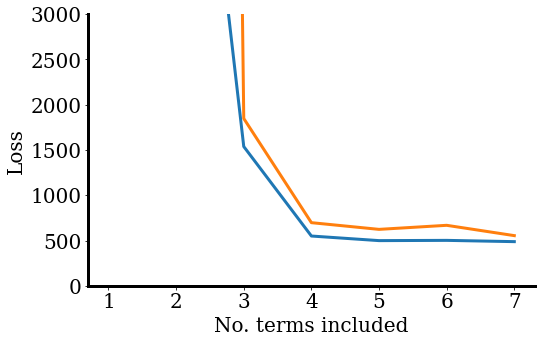

In [5]:
file_names = [
    'refit_ee_unpert_median_1_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-15_18:53:43.287690',
    'refit_ee_unpert_median_2_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-15_18:53:43.225812',
    'refit_ee_unpert_median_3_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-15_22:36:53.722297',
    'refit_ee_unpert_median_4_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-15_23:02:53.233227',
    'refit_ee_unpert_median_5_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-15_22:38:05.382317',
    'refit_ee_unpert_median_6_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-15_22:38:28.268643',
    'refit_ee_unpert_median_7_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_1000_2024-05-15_23:02:07.976636',
]

plt.rcParams['axes.linewidth'] = 3.0

all_losses = []
all_losses_test = []
for f in file_names:
    min_loss, min_loss_test = fetch_minimum_loss(f, 20, 12, 10)
    all_losses.append(min_loss)
    all_losses_test.append(min_loss_test)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 2.5 * scale))
format_axs(axs)

axs.plot(np.arange(1, 8), all_losses, lw=3)
axs.plot(np.arange(1, 8), all_losses_test, lw=3)
# axs.set_yscale('log')
axs.set_ylim(0, 3000)
axs.set_ylabel('Loss')
axs.set_xlabel('No. terms included')

In [29]:
def plot_elbo_curve(file_name, n_plasticity_coefs, n_time_constants, batch_size, runs, n_categories=1, full_rules_file_name=None):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    df_train = read_csv(train_data_path, read_header=False, start=1)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    
    all_losses_for_terms = np.array([losses[i:i + runs] for i in range(0,  len(losses), runs)])
    mean_losses_for_terms = np.array([np.mean(ls) for ls in all_losses_for_terms])
    std_losses_for_terms = np.array([np.std(ls) for ls in all_losses_for_terms])
    cis_for_terms = 1.96 * (std_losses_for_terms / np.sqrt(runs))
    
    cutoff = 600
    
    scale = 1.5
    gs = gridspec.GridSpec(5 * n_categories, 1)
    fig = plt.figure(figsize=(4.5 * scale, 3.3 * scale), tight_layout=True)
    axs = [fig.add_subplot(gs[:2]), fig.add_subplot(gs[2:5])]
    plt.rcParams['axes.linewidth'] = 3.0
    
    axs[1].set_ylabel('Loss')
    axs[0].set_xticks([])
    axs[0].set_xlim(0.5, 8)
    axs[0].set_xticklabels([])
    if full_rules_file_name is not None:
        axs[1].set_xticks(np.arange(9))
        axs[1].set_xticklabels(np.concatenate([np.arange(0, 8), ['All']]))
    else:
        axs[1].set_xticks(np.arange(8))
        axs[1].set_xticklabels(np.arange(0, 8))
    axs[1].set_xlabel('No. terms included')
    axs[1].set_xlim(0.5, 8)

    axs[0].set_yscale('log')
    axs[0].set_ylim(cutoff * 0.5, 1e9)
    axs[1].set_ylim(0, cutoff * 1.1)
    axs[0].set_yticks([1e3, 1e6, 1e9])

    axs[0].spines['bottom'].set_visible(False)
#     axs[0].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
#     axs[1].spines['right'].set_visible(False)
    
    for term_idx in np.arange(all_losses_for_terms.shape[0]):
        
        mask_over_cutoff = all_losses_for_terms[term_idx] > cutoff
        
        if np.median(all_losses_for_terms[term_idx]) > cutoff:
#             axs[0].errorbar([term_idx + 1.5], [np.median(all_losses_for_terms[term_idx])], yerr=np.std(all_losses_for_terms[term_idx]) / np.sqrt(100), color='black')
            axs[0].scatter([term_idx + 1.5], np.median(all_losses_for_terms[term_idx]), color='black')
        
        axs[0].scatter(
            (runs * [term_idx + 1] + np.random.normal(size=runs, scale=0.1))[mask_over_cutoff],
            all_losses_for_terms[term_idx][mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor='#076eb0',
            alpha=0.5,
            s=50, 
        )
        
        if np.median(all_losses_for_terms[term_idx]) <= cutoff:
#             axs[1].errorbar([term_idx + 1.5], [np.median(all_losses_for_terms[term_idx])], yerr=np.std(all_losses_for_terms[term_idx]) / np.sqrt(100), color='black')
            axs[1].scatter([term_idx + 1.5], np.median(all_losses_for_terms[term_idx]), color='black')
        
        axs[1].scatter(
            (runs * [term_idx + 1] + np.random.normal(size=runs, scale=0.1))[~mask_over_cutoff],
            all_losses_for_terms[term_idx][~mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor='#076eb0',
            alpha=0.5,
            s=50,
        )
    
#     axs[1].set_yscale('log')
    
    if full_rules_file_name is not None:
        train_data_path_fm = f'./sims_out/{full_rules_file_name}/train_data.csv'
        df_train_fm = read_csv(train_data_path_fm, read_header=False, start=1)
        
        losses_fm = df_train_fm[df_train_fm.columns[1]][:runs]
        
        mask_over_cutoff = losses_fm > cutoff
        
        axs[0].scatter(
            (runs * [term_idx + 2] + np.random.normal(size=runs, scale=0.15))[mask_over_cutoff],
            losses_fm[mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor='black',
            alpha=0.5,
        )
        
        axs[1].scatter(
            (runs * [term_idx + 2] + np.random.normal(size=runs, scale=0.15))[~mask_over_cutoff],
            losses_fm[~mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor='black',
            alpha=0.5,
        )
    
    set_font_size(axs[0], 20)
    set_font_size(axs[1], 20)
        
    fig.savefig(os.path.join(figure_path, 'test_refit_elbo_plot_pert.png'))
    fig.savefig(os.path.join(figure_path, 'test_refit_elbo_plot_pert.svg'))
        

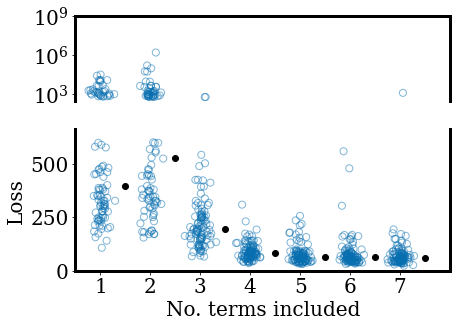

In [30]:
plot_elbo_curve(
    'decoder_ee_test_refit_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_2000_2024-05-18_11:00:58.405696',
    20,
    12,
    1,
    100,
    n_categories=1,
)

In [24]:
def cohen_d(x1, x2):
    s = np.sqrt((len(x1) * np.var(x1) + len(x2) * np.var(x2)) / (len(x1) + len(x2) - 2))
    return (np.mean(x2) - np.mean(x1)) / s

In [29]:
def plot_all_losses(file_names, n_plasticity_coefs, n_time_constants, batch_size, n_categories=1, colors=None, labels=None, scale=2):
    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants
    
    cutoff = 500
    
    gs = gridspec.GridSpec(5 * n_categories, 1)
    fig = plt.figure(figsize=(3 * scale, 3.5 * n_categories * scale), tight_layout=True)
    axs = [fig.add_subplot(gs[:2]), fig.add_subplot(gs[2:5])]
    
    axs[1].set_ylabel('Loss')
    axs[0].set_xticks([])
    axs[0].set_xlim(0, len(file_names) + 1)
    axs[0].set_xticklabels([])
#     axs[1].set_xticklabels(np.concatenate([np.arange(0, len(file_names)), ['All']]))
#     axs[1].set_xlabel('No. terms included')
    axs[1].set_xlim(0, len(file_names) + 1)
    axs[1].set_xticks(2 * np.arange(int(len(file_names)/2)) + 1.5)

    axs[0].set_yscale('log')
    axs[0].set_ylim(cutoff * 0.5, 1e5)
    axs[1].set_ylim(0, cutoff * 1.1)
    if labels is None:
        labels = ['Summed\nsynaptic'] + ['Meta-learned']  + ['Meta-learned\nwith turnover']
    axs[1].set_xticklabels(labels, rotation=-45, ha='left')

    axs[0].spines['bottom'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    
    if colors is None:
        colors = ['grey', 'green'] * 20
        
    all_losses = []
    
    for file_idx, file_name in enumerate(file_names):
        if type(n_plasticity_coefs) is list:
            curr_n_plasticity_coefs = n_plasticity_coefs[file_idx]
            curr_n_time_constants = n_time_constants[file_idx]
            
        else:
            curr_n_plasticity_coefs = n_plasticity_coefs
            curr_n_time_constants = n_time_constants
            
        train_data_path = f'./sims_out/{file_name}/train_data.csv'

        df_train = read_csv(train_data_path, read_header=False, start=2)
        
        losses = df_train[df_train.columns[1]]
        
        print(np.median(losses))
        
        all_losses.append(np.array(losses))
        
        over_cutoff = losses > cutoff
        
        axs[0].scatter(
            (len(losses[over_cutoff]) * [file_idx + 1 - 0.2] + np.random.normal(size=len(losses[over_cutoff]), scale=0.075)),
            losses[over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor=colors[file_idx],
            alpha=0.6,
            s=50,
        )
        
        axs[0].set_yticks([1e3, 1e5])
#         axs[0].set_yticklabels(['1e3', '1e6'], rotation=90)
        
        axs[1].scatter(
            (len(losses[~over_cutoff]) * [file_idx + 1 - 0.2] + np.random.normal(size=len(losses[~over_cutoff]), scale=0.075)),
            losses[~over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor=colors[file_idx],
            alpha=0.6,
            s=50,
        )
        
        
#         axs[1].errorbar([file_idx + 1 + 0.2],
#                         [np.median(losses)],
#                         yerr=np.std(losses) / np.sqrt(20), color='black', capsize=4, linestyle='')
        
        axs[1].scatter([file_idx + 1 + 0.2], [np.median(losses)], color='black')
    
    print(stats.kruskal(all_losses[1], all_losses[3]))
    print('Cohen d:', cohen_d(all_losses[1], all_losses[3]))
    print(stats.kruskal(all_losses[1], all_losses[5]))
    print('Cohen d:', cohen_d(all_losses[1], all_losses[5]))
    
    print(stats.kruskal(all_losses[0], all_losses[2]))
    print('Cohen d:', cohen_d(all_losses[0], all_losses[2]))
    print(stats.kruskal(all_losses[0], all_losses[4]))
    print('Cohen d:', cohen_d(all_losses[0], all_losses[4]))
        
    set_font_size(axs[0], 18)
    set_font_size(axs[1], 18)
    fig.savefig('figures/stress_test_comp_ila_best.png')
    fig.savefig('figures/stress_test_comp_ila_best.svg')
    
        

52.039290928733756
997.1634963440152
107.55289924025867
327.890637951166
125.34568932708942
260.06651962100943
KruskalResult(statistic=61.651325190384, pvalue=4.099911027836438e-15)
Cohen d: -0.3582053536701941
KruskalResult(statistic=102.14248622974071, pvalue=5.166843348845636e-24)
Cohen d: -0.4147434656037828
KruskalResult(statistic=78.26043132712834, pvalue=9.03129166653659e-19)
Cohen d: 0.032902270938850724
KruskalResult(statistic=87.88737227613422, pvalue=6.928962065003041e-21)
Cohen d: 0.17302313834410915


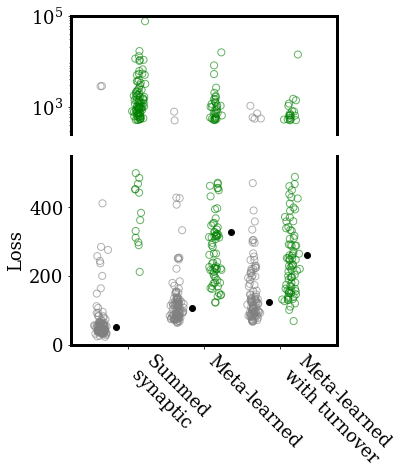

In [30]:
plot_all_losses([
    'ila_network_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_14:12:57.175017',
    'ila_network_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_700_2023-09-08_14:13:35.002314',
    'stress_test_ee_unpert_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_10:53:02.459275',
    'stress_test_ee_unpert_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_700_2023-09-08_10:54:41.632693',
    'stress_test_ee_pert_4_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_12:04:01.566259',
    'stress_test_ee_pert_4_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_700_2023-09-08_12:05:05.484616'
], 20, 12, 1, n_categories=1)

85.27786655049337
149.1735868084564
71.81827701772886
94.72570345501195
70.16949059770299
96.43421119089761
KruskalResult(statistic=24.573447279248967, pvalue=7.153062209357824e-07)
Cohen d: -0.4486000553064189
KruskalResult(statistic=31.078294748920484, pvalue=2.478272083676993e-08)
Cohen d: -0.4383079284083096
KruskalResult(statistic=4.7591508199091095, pvalue=0.029142922724968854)
Cohen d: -0.2943241221805791
KruskalResult(statistic=5.7710791484204265, pvalue=0.016292027007972432)
Cohen d: -0.2979197293855712


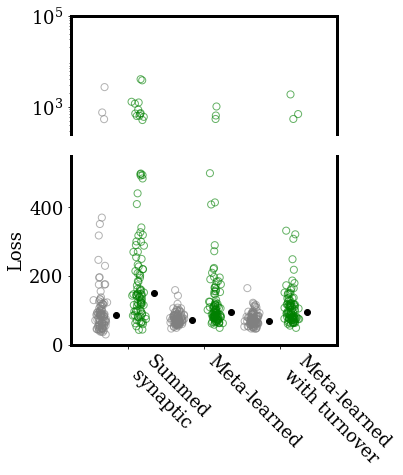

In [31]:
plot_all_losses([
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_14:39:56.146669',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_14:59:53.689189',
#     'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_22:43:26.962529',
#     'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:01:11.254902',
#     'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_22:43:34.792980',
#     'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:02:29.283637',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_22:43:34.947825',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:03:19.380426',
    
#     'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_23:37:09.008452',
#     'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:57:30.610154',
#     'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_23:37:09.008463',
#     'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:57:37.605892',
#     'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-19_00:18:58.456672',
#     'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-19_00:34:53.332226',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_18:21:35.728658',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_18:43:52.679492',
#     'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_18:21:47.392058',
#     'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_18:44:24.970776',
    
#     'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_14:40:00.662790',
#     'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_15:01:33.544577',
#     'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_15:23:28.832139',
#     'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_15:44:43.752692',
#     'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_15:26:17.224148',
#     'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_15:49:02.975763',
#     'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_16:04:44.878823',
#     'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_16:24:10.329350',





], 20, 12, 1, labels=None, n_categories=1)

In [45]:
def plot_median_loss_trajs(file_names, n_plasticity_coefs, n_time_constants, batch_size, n_categories=1, colors=None, labels=None, scale=2):
    cutoff = 500
    
    scale = 1.5
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 4 * scale))
    axs.set_ylabel('Loss')
    axs.set_xlabel('Turnover rate')
    axs.set_xticks(np.arange(2))
    axs.set_xticklabels(['0', '0.0007'], rotation=45)
    set_font_size(axs, 18)
    axs.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    plt.subplots_adjust(wspace=0, hspace=0.05)
    
#     if labels is None:
#         labels = ['Summed\nsynaptic'] + ['Meta-learned']  + ['Meta-learned\nwith turnover']
    
    colors = ['red'] * 3 + ['blue'] * 3 + ['green'] * 5

    median_losses = []
    
    for file_idx, file_name in enumerate(file_names):
        train_data_path = f'./sims_out/{file_name}/train_data.csv'

        df_train = read_csv(train_data_path, read_header=False, start=2)
        
        losses = df_train[df_train.columns[1]]
        
        median_losses.append(np.median(losses))
        
        if file_idx % 2 == 1:
#             noise = np.random.normal(size=2, scale=0.05)
            axs.plot(np.arange(2), median_losses, color=colors[int(file_idx/2)])
            axs.scatter(np.arange(2), median_losses, color=colors[int(file_idx/2)], s=40)
            median_losses = []
        
    fig.savefig('figures/stress_test_comp_ila.png')
    fig.savefig('figures/stress_test_comp_ila.svg')

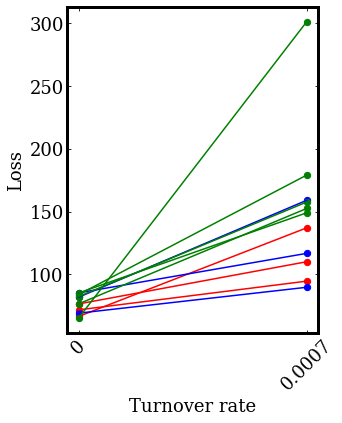

In [46]:
plot_median_loss_trajs([
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_22:43:26.962529',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:01:11.254902',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_22:43:34.792980',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:02:29.283637',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_22:43:34.947825',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:03:19.380426',
    
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_23:37:09.008452',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:57:30.610154',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_23:37:09.008463',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:57:37.605892',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-19_00:18:58.456672',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-19_00:34:53.332226',
    
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_14:39:56.146669',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_14:59:53.689189',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_14:40:00.662790',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_15:01:33.544577',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_15:23:28.832139',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_15:44:43.752692',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_15:26:17.224148',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_15:49:02.975763',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_16:04:44.878823',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_16:24:10.329350',





], 20, 12, 1, labels=[''] * 11, n_categories=1)

In [119]:
def plot_median_losses(file_names, n_plasticity_coefs, n_time_constants, batch_size, n_categories=1, colors=None, labels=None, scale=2):
    plt.rc('font', family='serif')
    
    cutoff = 500
    scale = 1.5
    fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 4 * scale))
    axs.set_ylabel('Loss')
    axs.set_xlabel('Turnover rate')
    axs.set_xticks([1, 4])
    axs.set_xticklabels(['0', '0.0007'])
    set_font_size(axs, 18)
    axs.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    plt.subplots_adjust(wspace=0, hspace=0.05)
    
#     if labels is None:
#         labels = ['Summed\nsynaptic'] + ['Meta-learned']  + ['Meta-learned\nwith turnover']
    
    colors = ['red'] * 10 + ['green'] * 10 + ['purple'] * 10
    positions = [0, 3] * 5 + [1, 4] * 5 + [2, 5] * 5
    
    last_loss = 0
    
    for file_idx, file_name in enumerate(file_names):
        train_data_path = f'./sims_out/{file_name}/train_data.csv'

        df_train = read_csv(train_data_path, read_header=False, start=2)
        
        losses = df_train[df_train.columns[1]]
        
        if file_idx % 2 == 1 and last_loss > 100:
            continue
        last_loss = np.median(losses)
        if file_idx % 2 == 0 and np.median(losses) > 100:
            continue
            
        axs.scatter(positions[file_idx] + np.random.normal(size=1, scale=0.05), np.median(losses), s=60, facecolor='none', edgecolor=colors[file_idx])
        
    fig.savefig('figures/stress_test_comp_ila_all.png')
    fig.savefig('figures/stress_test_comp_ila_all.svg')

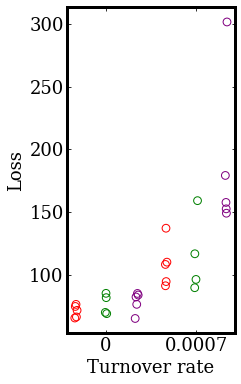

In [120]:
plot_median_losses([
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_22:43:26.962529',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:01:11.254902',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_22:43:34.792980',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:02:29.283637',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_22:43:34.947825',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:03:19.380426',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_19:03:21.841039',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_19:22:50.886538',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_19:03:21.841040',
    'decoder_ee_stress_test_2_unpert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_19:23:35.167084',

    
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_23:37:09.008452',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:57:30.610154',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-18_23:37:09.008463',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-18_23:57:37.605892',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-19_00:18:58.456672',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-19_00:34:53.332226',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_18:21:35.728658',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_18:43:52.679492',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_18:21:47.392058',
    'decoder_ee_stress_test_2_pert_det_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_18:44:24.970776',
    
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_14:39:56.146669',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_14:59:53.689189',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_14:40:00.662790',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_15:01:33.544577',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_15:23:28.832139',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_15:44:43.752692',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_15:26:17.224148',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_15:49:02.975763',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_444_2024-05-20_16:04:44.878823',
    'ila_rules_det_input_test_nonmult_bound_BATCH_1_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.00072_FRACI_0.75_SEED_444_2024-05-20_16:24:10.329350',





], 20, 12, 1, labels=[''] * 11, n_categories=1)